# OpenPowerlifting Dataset Machine Learning for Age/Bodyweight Regression Script


In [1]:
# Import Necessary Libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib
import os
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

### Loading the data
Make sure to check the Preprocess script/notebook for instructions for preprocessing the data before using this notebook. 

In [2]:
USA_Male_Powerlifter_data = pd.read_csv('data/USA_Male_Powerlifters.csv', low_memory = False)
print(str(USA_Male_Powerlifter_data.shape))
USA_Male_Powerlifter_data.head(5)

(145921, 34)


Age  BodyweightKg  Squat1Kg  Squat2Kg  Squat3Kg  Best3SquatKg  Bench1Kg  \
0  20.5         74.70     150.0     160.0     170.0         170.0     100.0   
1  20.5         67.60     117.5     130.0     132.5         132.5      67.5   
2  21.5         95.85     165.0     182.5     192.5         192.5     125.0   
3  21.5         80.90     175.0     190.0    -200.0         190.0      90.0   
4  20.5         80.85     130.0     137.5     145.0         145.0      75.0   

   Bench2Kg  Bench3Kg  Best3BenchKg  ...  Bench3Success  Deadlift1Success  \
0     110.0     120.0         120.0  ...              1                 1   
1      75.0      77.5          77.5  ...              1                 1   
2    -135.0    -135.0         125.0  ...              0                 1   
3      97.5    -102.5          97.5  ...              0                 1   
4      77.5      82.5          82.5  ...              1                 1   

   Deadlift2Success  Deadlift3Success  Squat_BW_Ratio  Bench_BW_Ratio  \
0                 1                 1        2.275770        1.606426   
1                 1                 1        1.960059        1.146450   
2                 1                 0        2.008346        1.304121   
3                 1                 1        2.348578        1.205192   
4                 1                 1        1.793445        1.020408   

   Deadlift_BW_Ratio  Squat_Total_Ratio  Bench_Total_Ratio  \
0           2.844712           0.338308           0.238806   
1           2.144970           0.373239           0.218310   
2           1.956182           0.381188           0.247525   
3           2.472188           0.389744           0.200000   
4           2.473717           0.339181           0.192982   

   Deadlift_Total_Ratio  
0              0.422886  
1              0.408451  
2              0.371287  
3              0.410256  
4              0.467836  

[5 rows x 34 columns]

In [3]:
USA_Female_Powerlifter_data = pd.read_csv('data/USA_Female_Powerlifters.csv', low_memory = False)
print(str(USA_Female_Powerlifter_data.shape))
USA_Female_Powerlifter_data.head(5)

(77586, 34)


Age  BodyweightKg  Squat1Kg  Squat2Kg  Squat3Kg  Best3SquatKg  Bench1Kg  \
0  21.5         55.55      92.5      97.5    -102.5          97.5      42.5   
1  20.5         74.75     160.0     170.0     177.5         177.5      77.5   
2  22.0         80.40     140.0     150.0     155.0         155.0      57.5   
3  64.5         55.45      25.0       0.0       0.0          25.0      25.0   
4  38.5         55.60      82.5      85.0      87.5          87.5      45.0   

   Bench2Kg  Bench3Kg  Best3BenchKg  ...  Bench3Success  Deadlift1Success  \
0      45.0     -47.5          45.0  ...              0                 1   
1      82.5      85.0          85.0  ...              1                 1   
2      62.5      67.5          67.5  ...              1                 1   
3       0.0       0.0          25.0  ...              0                 1   
4      50.0     -52.5          50.0  ...              0                 1   

   Deadlift2Success  Deadlift3Success  Squat_BW_Ratio  Bench_BW_Ratio  \
0                 0                 0        1.755176        0.810081   
1                 1                 1        2.374582        1.137124   
2                 1                 1        1.927861        0.839552   
3                 0                 0        0.450857        0.450857   
4                 1                 0        1.573741        0.899281   

   Deadlift_BW_Ratio  Squat_Total_Ratio  Bench_Total_Ratio  \
0           1.800180           0.402062           0.185567   
1           2.474916           0.396648           0.189944   
2           2.176617           0.389937           0.169811   
3           0.991885           0.238095           0.238095   
4           1.888489           0.360825           0.206186   

   Deadlift_Total_Ratio  
0              0.412371  
1              0.413408  
2              0.440252  
3              0.523810  
4              0.432990  

[5 rows x 34 columns]

# Predicting BodyweightKg from all other features

## Male:

### Splitting into Target Values and Features

In [4]:
USA_Male_Powerlifter_data_no_bodyweight = USA_Male_Powerlifter_data.drop(columns='BodyweightKg').sample(50000, random_state = 42)
male_bodyweights = USA_Male_Powerlifter_data['BodyweightKg'].sample(50000, random_state = 42)
USA_Male_Powerlifter_data_no_bodyweight.head(5)
#male_bodyweights.head(5)

Age  Squat1Kg  Squat2Kg  Squat3Kg  Best3SquatKg  Bench1Kg  Bench2Kg  \
74908   79.5      42.5     -62.5      67.5          67.5      70.0     -80.0   
112611  20.5     207.5     217.5     230.0         230.0     112.5     117.5   
80245   25.5     170.0     180.0     190.0         190.0     122.5     127.5   
66158   19.5     170.0     182.5     185.0         185.0     105.0     112.5   
118633  18.5     162.5    -172.5     172.5         172.5     110.0     115.0   

        Bench3Kg  Best3BenchKg  Deadlift1Kg  ...  Bench3Success  \
74908      -80.0          70.0        137.5  ...              0   
112611    -122.5         117.5        242.5  ...              0   
80245     -130.0         127.5        197.5  ...              0   
66158      117.5         117.5        215.0  ...              1   
118633     117.5         117.5        182.5  ...              1   

        Deadlift1Success  Deadlift2Success  Deadlift3Success  Squat_BW_Ratio  \
74908                  1                 1                 1        0.935162   
112611                 1                 1                 0        2.356557   
80245                  1                 1                 0        2.355859   
66158                  1                 1                 1        2.581996   
118633                 1                 1                 1        1.938202   

        Bench_BW_Ratio  Deadlift_BW_Ratio  Squat_Total_Ratio  \
74908         0.969798           2.008867           0.238938   
112611        1.203893           2.638320           0.380165   
80245         1.580905           2.603844           0.360190   
66158         1.639916           3.279833           0.344186   
118633        1.320225           2.247191           0.352041   

        Bench_Total_Ratio  Deadlift_Total_Ratio  
74908            0.247788              0.513274  
112611           0.194215              0.425620  
80245            0.241706              0.398104  
66158            0.218605              0.437209  
118633           0.239796              0.408163  

[5 rows x 33 columns]

### Tuning a Decision Tree for Insights on A Tuned Random Forest Classifier

In [5]:
X_train, X_test, y_train, y_test = train_test_split(USA_Male_Powerlifter_data_no_bodyweight, male_bodyweights, test_size=0.20, random_state=42)
DT_parameters = {'max_depth':(None, 1, 3, 5, 10, 20, 30), 'min_samples_split':(2, 5, 10, 20, 50), 'min_samples_leaf': (1, 2, 5, 10, 15, 25), }
DT_cv = DecisionTreeRegressor(random_state = 42, criterion='friedman_mse')
DT_grid = GridSearchCV(estimator = DT_cv, param_grid = DT_parameters, n_jobs = -1, scoring='neg_mean_squared_error')
DT_grid.fit(X_train, y_train)
DT_grid.best_estimator_.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'max_depth': 20,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 42,
 'splitter': 'best'}

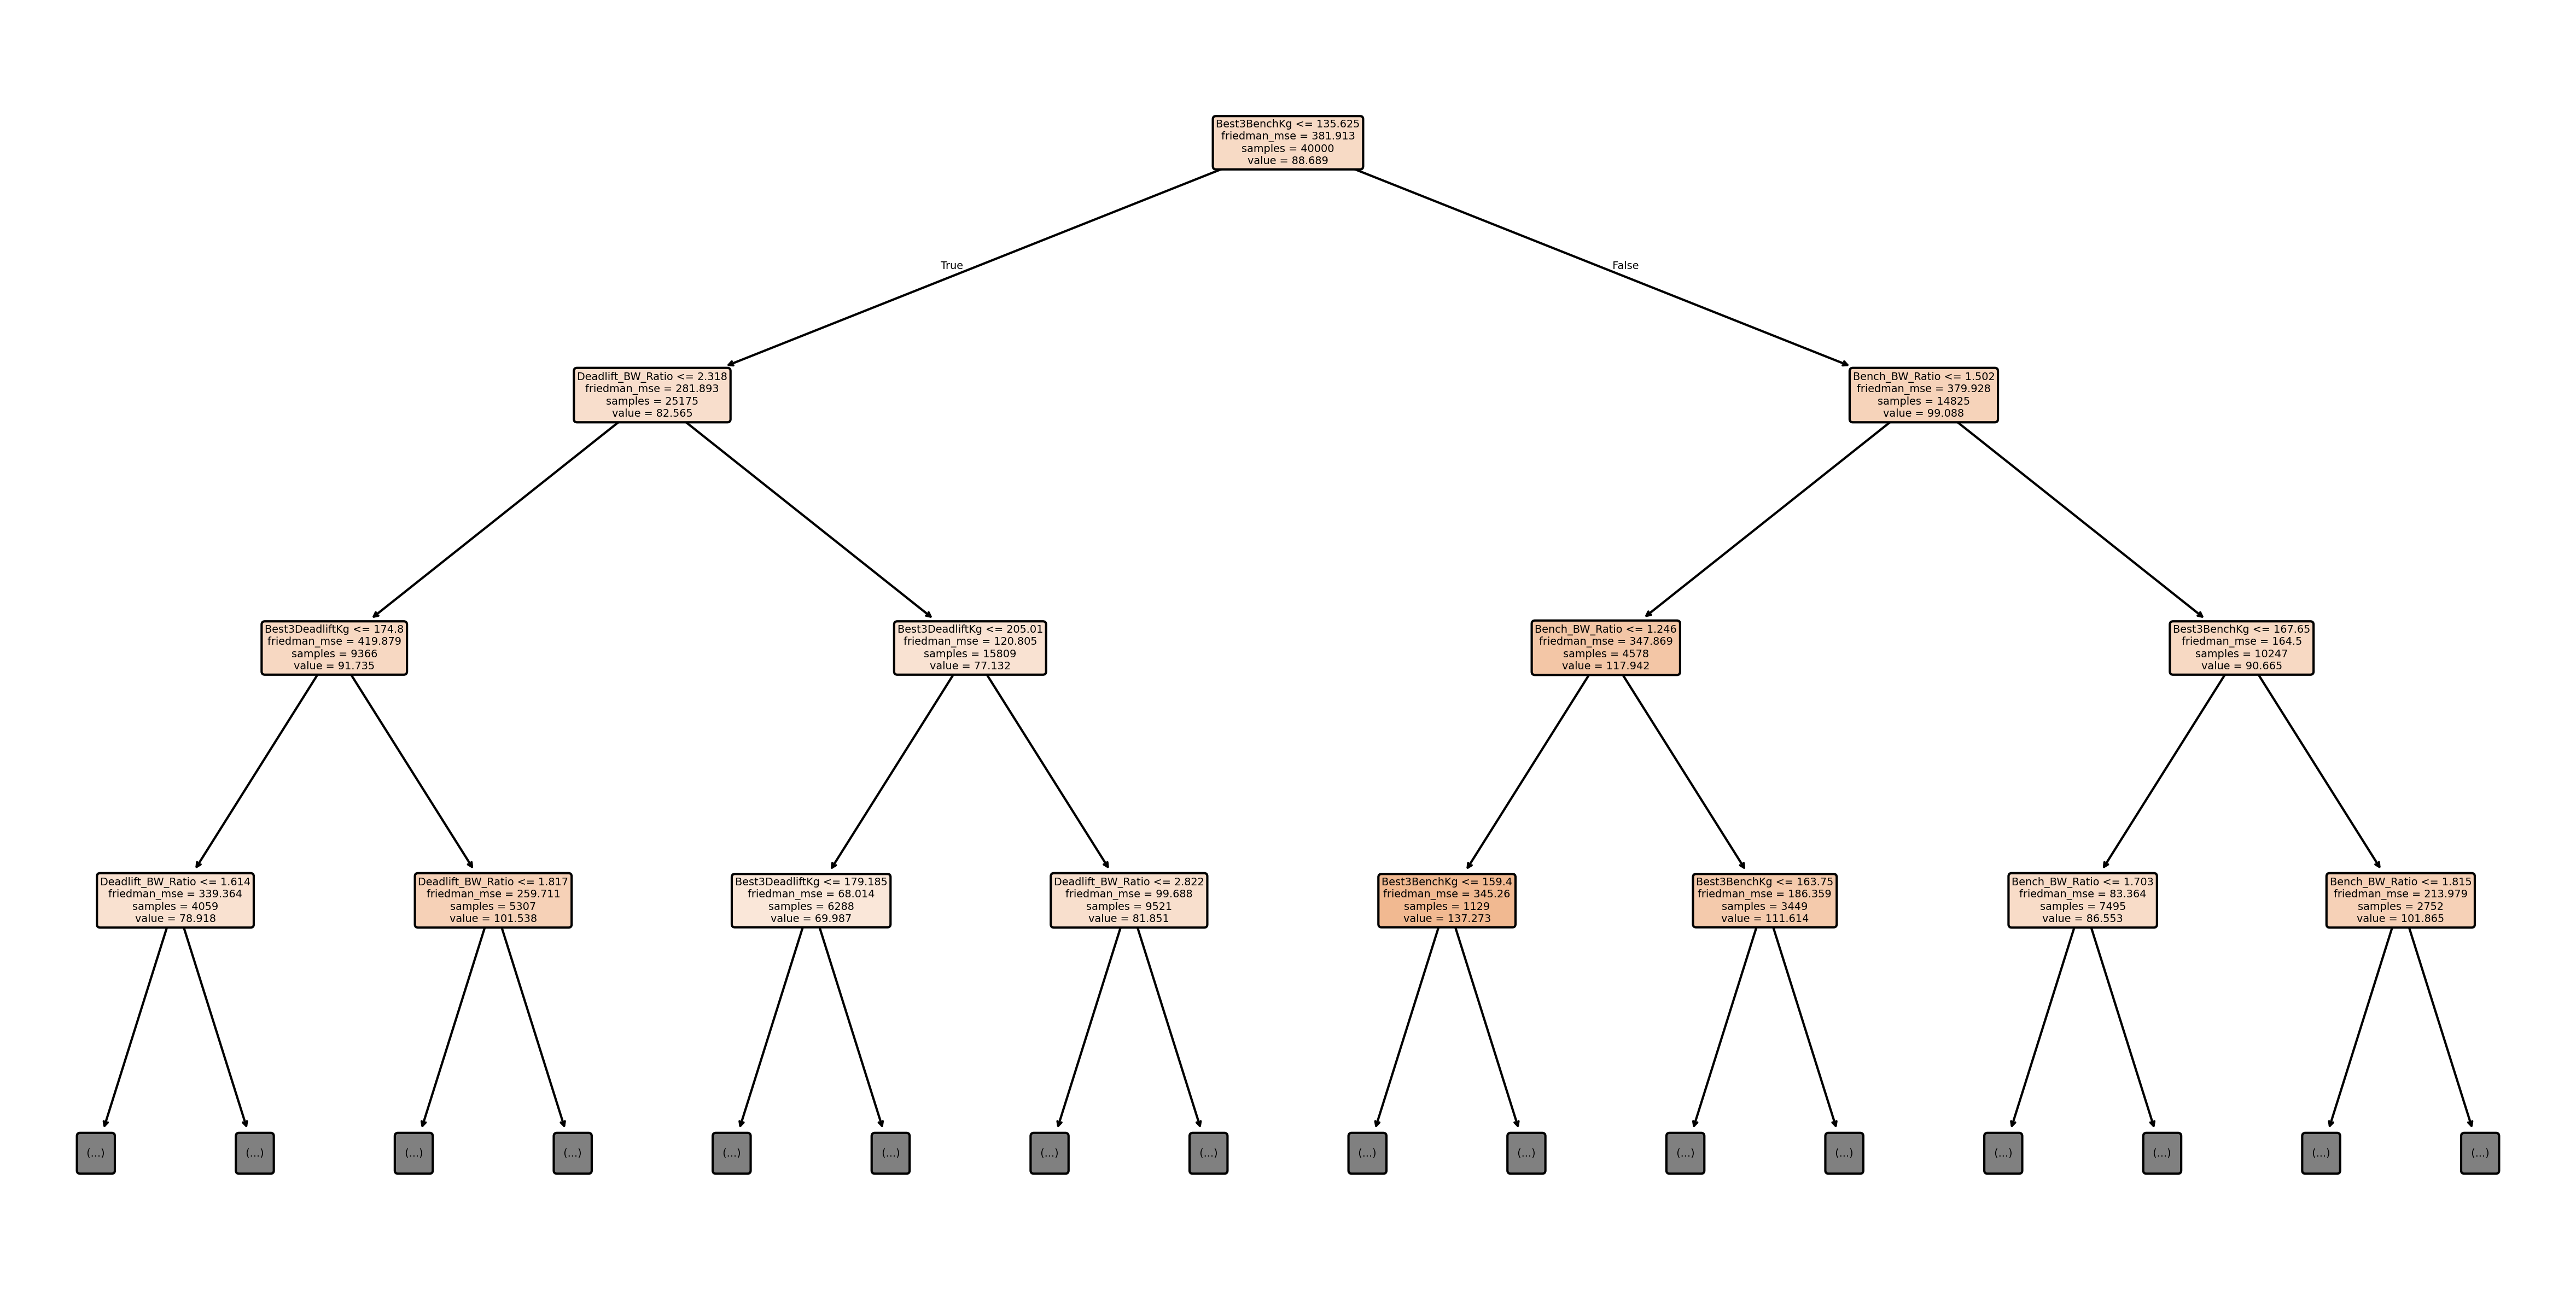

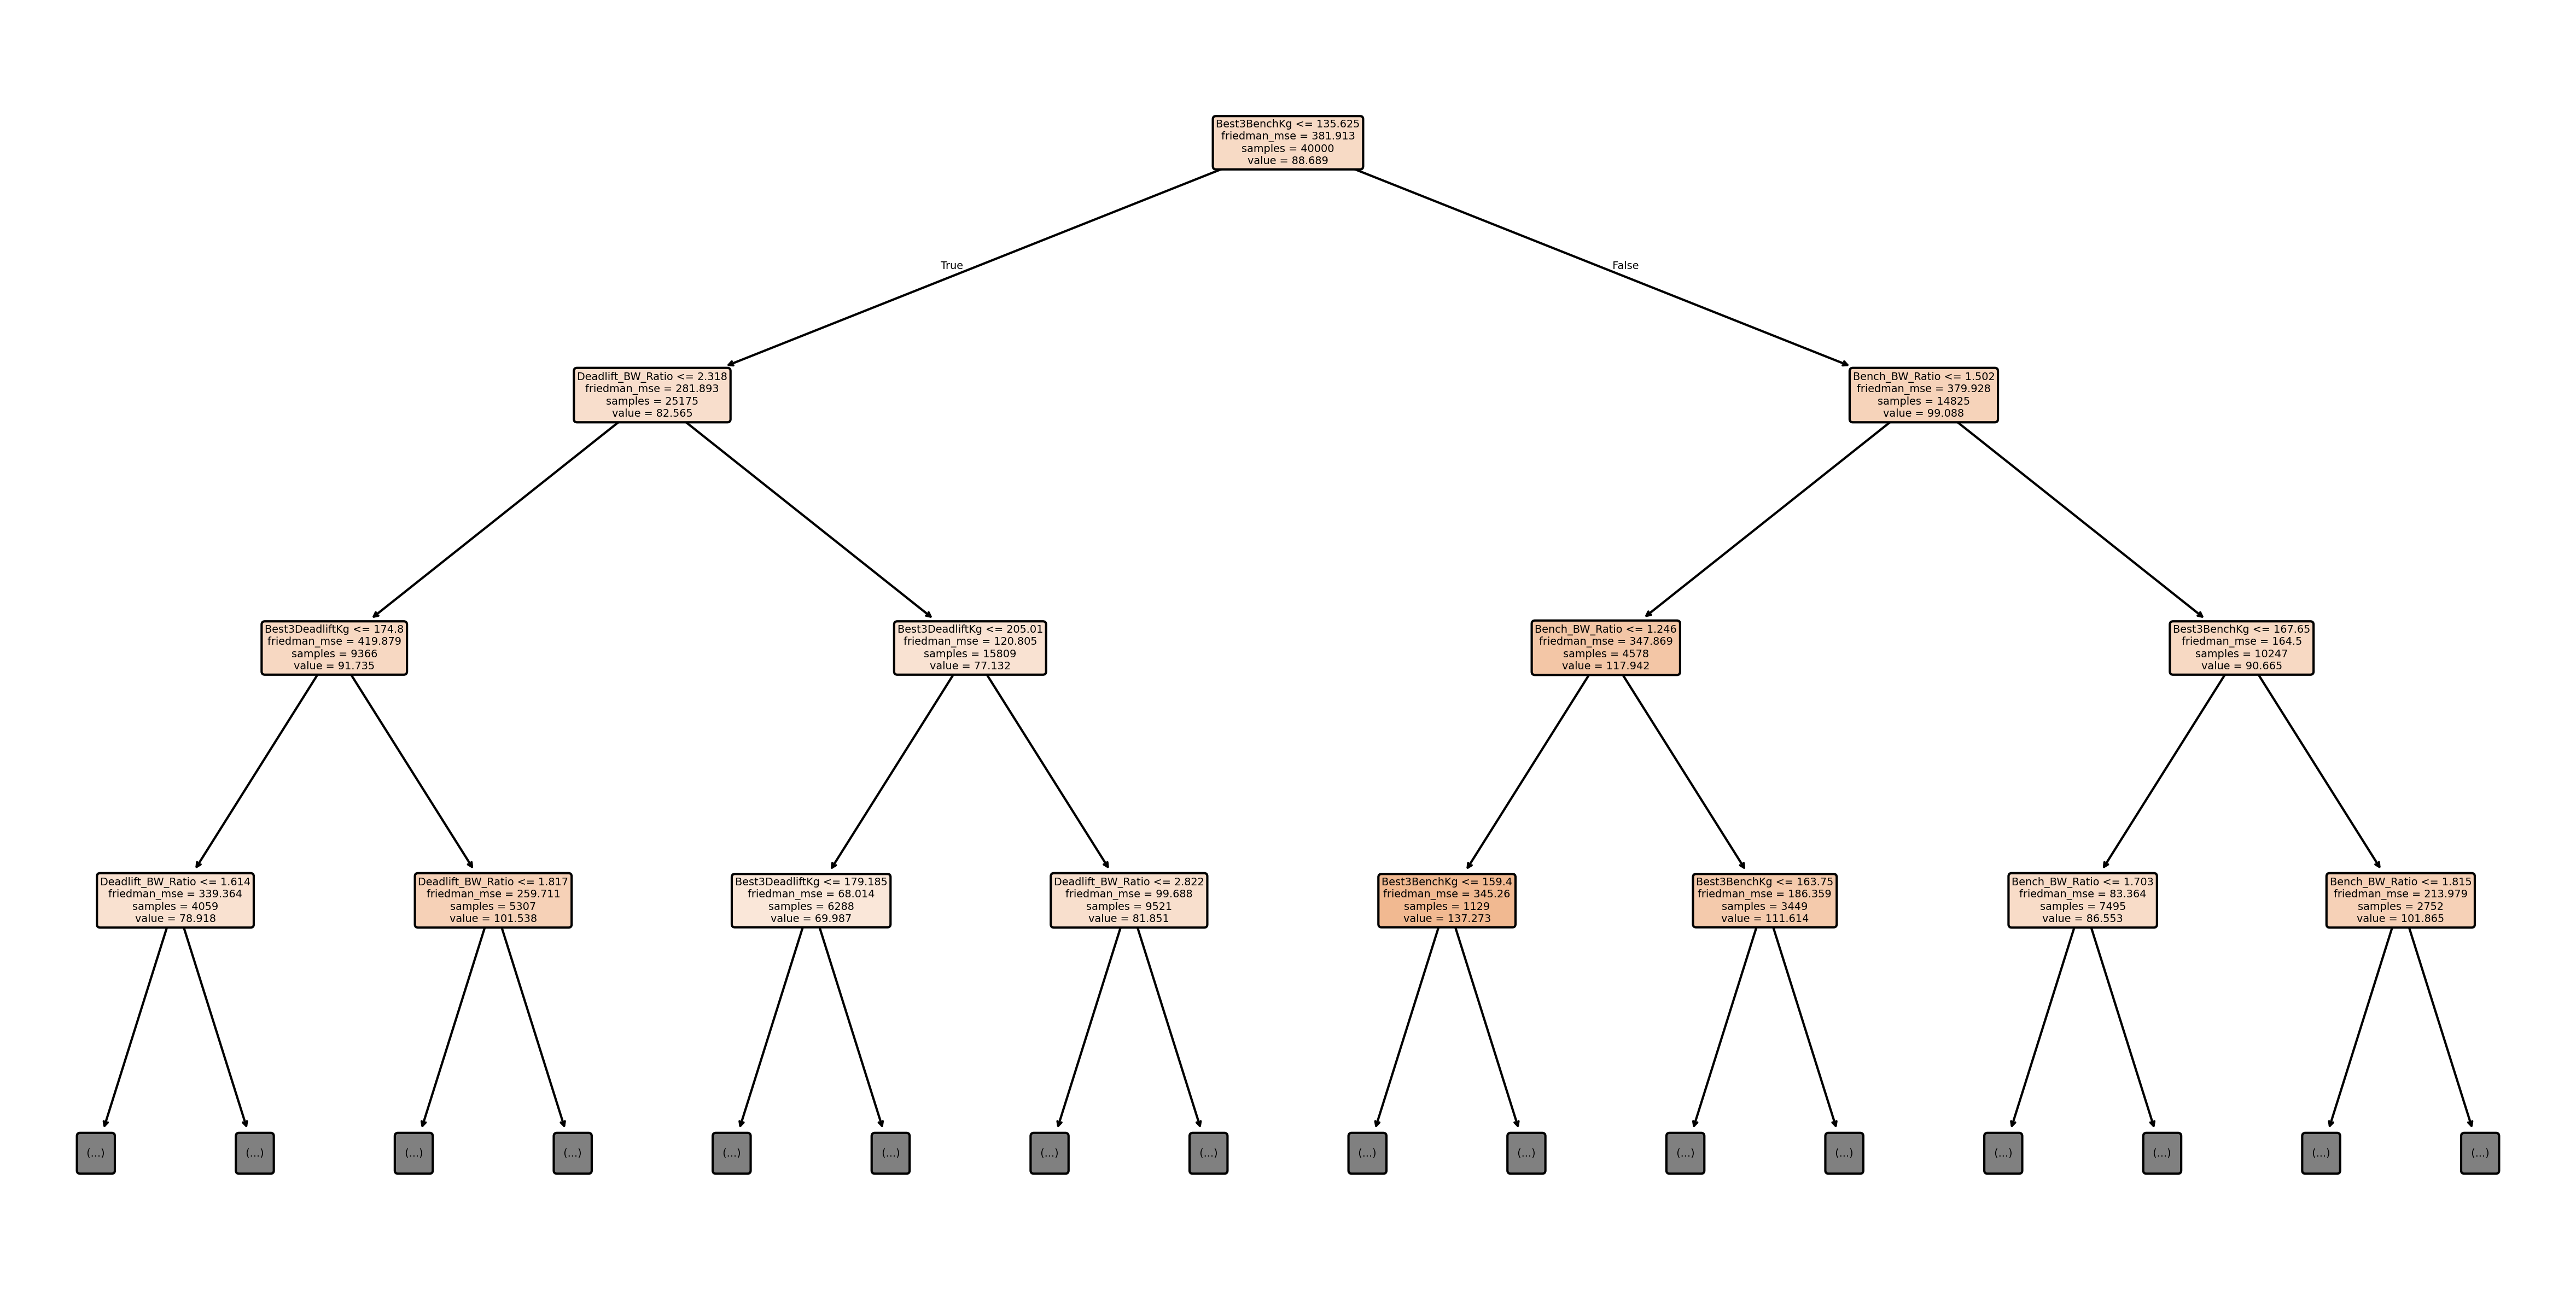

In [6]:
best_tree = DT_grid.best_estimator_
plt.figure(figsize=(20,10))
plot_tree(best_tree, feature_names=X_train.columns, filled=True, rounded=True, max_depth=3)  # can adjust depth for readability
plt.show()
plt.figure(figsize=(20,10))
plot_tree(best_tree, feature_names=X_train.columns, filled=True, rounded=True, max_depth=3)
plt.savefig('dtrees/best_tree_model_male_bodywight.png', format='png')

In [7]:
importances = best_tree.feature_importances_
feat_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feat_importance_df = feat_importance_df.sort_values(by='Importance', ascending=False)
print(feat_importance_df.head(10))

              Feature  Importance
8        Best3BenchKg    0.268531
28     Bench_BW_Ratio    0.267008
29  Deadlift_BW_Ratio    0.241462
12    Best3DeadliftKg    0.219075
13            TotalKg    0.001567
15              Wilks    0.000606
3            Squat3Kg    0.000331
11        Deadlift3Kg    0.000281
6            Bench2Kg    0.000207
0                 Age    0.000142


In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

models = {
   'Random Forest': RandomForestRegressor(random_state=42, n_jobs = -1, criterion = 'friedman_mse'),
   'Gradient Boosting': GradientBoostingRegressor(random_state=42, criterion = 'friedman_mse'),
   #'XGBoost': xgb.XGBRegressor(random_state=42),
   #'HistGradientBoosting': HistGradientBoostingRegressor(random_state=42),
    'ElasticNet': ElasticNet(random_state=42, max_iter=2000),
   # 'SVR': SVR(verbose=False),
    'Ridge': Ridge(random_state=42),
    'Lasso': Lasso(random_state=42)
}

param_grids = {
    #'Random Forest': {
    #    'n_estimators': [100, 200, 300],
    #    'max_depth': [None],
    #    'min_samples_split': [2],
    #    'min_samples_leaf': [5]
    #},
    'Gradient Boosting': {
        'n_estimators': [100],
        'learning_rate': [0.1, 0.5, 1],
        'max_depth': [20],             
        'min_samples_split': [5],
        'min_samples_leaf': [2],
        'max_features': [None],
    },
    #'XGBoost': {
    #    'n_estimators': [100, 200],
    #    'learning_rate': [0.1, 0.2],
    #    'max_depth': [None]
    #},
    'Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [20],             # None from best DT, plus nearby values
        'min_samples_split': [5],
        'min_samples_leaf': [2],
        'max_features': [None],
        'bootstrap': [True]
    },
    'HistGradientBoosting': {
        'learning_rate': [0.05, 0.1, 0.2],
        'max_iter': [100, 200],
        'max_leaf_nodes': [None],
        'min_samples_leaf': [2],
        'max_depth': [None]
    },
    #'XGBoost': {
    #    'n_estimators': [100, 200, 300],
    #    'learning_rate': [0.05, 0.1, 0.2],
    #    'max_depth': [0],               # drop None for XGB (doesn’t support None)
    #    'subsample': [0.8, 1.0],
    #    'colsample_bytree': [0.8, 1.0],
    #    'min_child_weight': [2, 4],              # aligns with min_samples_leaf from DT
    #    'reg_alpha': [0, 0.1],                   # L1 regularization
    #    'reg_lambda': [1, 5]                     # L2 regularization
    #},
    'ElasticNet': {
        'alpha': [0.1, 1.0, 10.0],
        'l1_ratio': [0.1, 0.5, 0.7, 1.0]
    },
    #'SVR': {
    #    'C': [1, 10],
    #    'gamma': ['scale'],
    #    'kernel': ['rbf']
    #},
    'Ridge' : {
        'alpha': [0.01, 0.1, 1.0, 10.0],
        'max_iter': [10000],
        'solver': ['saga']
    },
    'Lasso' : {
        'alpha': [0.01, 0.1, 1.0, 5, 10],
        'max_iter': [50000]
    }
    
}

best_models = {}
loss_curves = {}

os.makedirs("loss_curves", exist_ok=True)

for model_name, model in models.items():
    print(f"\nTuning {model_name}...")
    clf = GridSearchCV(model, param_grids[model_name], cv=5, n_jobs=-1, scoring='neg_mean_squared_error', return_train_score=True)
    clf.fit(X_scaled, y_train)

    best_model = clf.best_estimator_
    best_models[model_name] = best_model
    print(f"{model_name} Best Parameters: {clf.best_params_}")
    
    # Store loss curve
    loss_df = pd.DataFrame(clf.cv_results_)
    loss_curves[model_name] = -loss_df[['mean_train_score', 'mean_test_score']]  # Make positive MSE

    # Plot and save loss curve
    plt.figure(figsize=(6, 4))
    plt.plot(loss_curves[model_name]['mean_train_score'], label='Train MSE')
    plt.plot(loss_curves[model_name]['mean_test_score'], label='Validation MSE')
    plt.title(f"{model_name} Loss Curve")
    plt.xlabel("Hyperparameter Configurations")
    plt.ylabel("MSE")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Save plot to PNG
    filename = f"loss_curves/{model_name.replace(' ', '_')}_loss_curve_male_bodyweight.png"
    plt.savefig(filename)
    plt.close()  # Closes the figure to avoid displaying all of them inline


Tuning Random Forest...
Random Forest Best Parameters: {'bootstrap': True, 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}

Tuning Gradient Boosting...
Gradient Boosting Best Parameters: {'learning_rate': 0.1, 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}

Tuning ElasticNet...
ElasticNet Best Parameters: {'alpha': 0.1, 'l1_ratio': 1.0}

Tuning Ridge...
Ridge Best Parameters: {'alpha': 0.01, 'max_iter': 10000, 'solver': 'saga'}

Tuning Lasso...
Lasso Best Parameters: {'alpha': 0.01, 'max_iter': 50000}


In [9]:
# Feature importance
print("\nFeature Importances:\n")
for name, model in best_models.items():
    print(f"\n{name}:")

    if hasattr(model, "feature_importances_"):  # Tree-based
        importances = model.feature_importances_
    elif name in ['ElasticNet', 'Ridge', 'Lasso'] and hasattr(model, 'coef_'):
        importances = np.abs(model.coef_)
    else:
        # Fallback to permutation importance
        result = permutation_importance(model, X_scaled, y_train, n_repeats=10, random_state=42, n_jobs=-1)
        importances = result.importances_mean

    for feature, score in sorted(zip(X_train.columns, importances), key=lambda x: x[1], reverse=True)[:10]:
        print(f"{feature}: {score:.4f}")


Feature Importances:


Random Forest:
Deadlift_BW_Ratio: 0.3116
Best3DeadliftKg: 0.1881
Bench_BW_Ratio: 0.1710
Best3BenchKg: 0.1656
TotalKg: 0.1526
Best3SquatKg: 0.0033
Squat_BW_Ratio: 0.0030
Glossbrenner: 0.0008
Deadlift1Kg: 0.0005
Age: 0.0004

Gradient Boosting:
Best3BenchKg: 0.2690
Bench_BW_Ratio: 0.2684
Deadlift_BW_Ratio: 0.2399
Best3DeadliftKg: 0.2178
TotalKg: 0.0023
Deadlift3Kg: 0.0003
Deadlift2Kg: 0.0003
Wilks: 0.0003
Bench2Kg: 0.0002
Dots: 0.0002

ElasticNet:
Wilks: 12.8708
Deadlift_BW_Ratio: 12.1892
Best3DeadliftKg: 10.8630
Squat_BW_Ratio: 8.4951
Bench_BW_Ratio: 7.5330
Deadlift_Total_Ratio: 2.7750
Best3BenchKg: 2.2322
Age: 0.3068
Squat1Kg: 0.0000
Squat2Kg: 0.0000

Ridge:
Dots: 156.9782
Wilks: 142.1839
Goodlift: 113.9351
Deadlift_BW_Ratio: 33.2473
Best3SquatKg: 22.2257
Squat_BW_Ratio: 17.5712
Bench_BW_Ratio: 17.2961
Glossbrenner: 12.5332
TotalKg: 9.4375
Best3BenchKg: 7.3831

Lasso:
Wilks: 21.5618
Deadlift_BW_Ratio: 15.8136
Best3DeadliftKg: 12.9338
Bench_BW_Ratio: 8.9549
Squat_

In [10]:
# Predict on Test Dataset and Performance
# Dictionary to store test results
test_results = {}
X_test_scaled = scaler.transform(X_test)
# Predict and evaluate
for name, model in best_models.items():
    y_pred = model.predict(X_test_scaled)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    test_results[name] = {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    }
#    print(f"{name} Performance:")
#    print(f"  RMSE: {rmse:.4f}")
#    print(f"  MAE : {mae:.4f}")
#    print(f"  R²  : {r2:.4f}\n")
pd.DataFrame(test_results).T.sort_values(by="RMSE")

RMSE       MAE        R2
Gradient Boosting  0.897227  0.276102  0.997841
Random Forest      0.973277  0.192334  0.997460
Ridge              3.469402  2.017086  0.967722
Lasso              3.941062  2.227610  0.958349
ElasticNet         4.080500  2.348079  0.955350

## Female: 

### Splitting into Target Values and Features

In [11]:
USA_Female_Powerlifter_data_no_bodyweight = USA_Female_Powerlifter_data.drop(columns='BodyweightKg').sample(50000, random_state = 42)
female_bodyweights = USA_Female_Powerlifter_data['BodyweightKg'].sample(50000, random_state = 42)
USA_Female_Powerlifter_data_no_bodyweight.head(5)
#female_bodyweights.head(5)

Age  Squat1Kg  Squat2Kg  Squat3Kg  Best3SquatKg  Bench1Kg  Bench2Kg  \
51060  52.5      65.0      70.0      80.0          80.0      35.0      40.0   
27622  24.5     137.5     147.5     155.0         155.0      82.5      87.5   
32677  22.5     100.0     105.0    -110.0         105.0      52.5     -55.0   
15056  25.0     132.5     140.0     142.5         142.5      85.0      90.0   
36063  28.5      72.5      85.0      95.0          95.0      42.5      47.5   

       Bench3Kg  Best3BenchKg  Deadlift1Kg  ...  Bench3Success  \
51060      42.5          42.5        105.0  ...              1   
27622      92.5          92.5        155.0  ...              1   
32677     -55.0          52.5        137.5  ...              0   
15056      95.0          95.0       -175.0  ...              1   
36063     -50.0          47.5         87.5  ...              0   

       Deadlift1Success  Deadlift2Success  Deadlift3Success  Squat_BW_Ratio  \
51060                 1                 1                 1        1.433692   
27622                 1                 1                 0        2.296296   
32677                 1                 1                 1        1.944444   
15056                 0                 1                 1        1.708633   
36063                 1                 1                 0        1.282051   

       Bench_BW_Ratio  Deadlift_BW_Ratio  Squat_Total_Ratio  \
51060        0.761649           2.195341           0.326531   
27622        1.370370           2.444444           0.375758   
32677        0.972222           2.731481           0.344262   
15056        1.139089           2.188249           0.339286   
36063        0.641026           1.349528           0.391753   

       Bench_Total_Ratio  Deadlift_Total_Ratio  
51060           0.173469              0.500000  
27622           0.224242              0.400000  
32677           0.172131              0.483607  
15056           0.226190              0.434524  
36063           0.195876              0.412371  

[5 rows x 33 columns]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(USA_Female_Powerlifter_data_no_bodyweight, female_bodyweights, test_size=0.20, random_state=42)
DT_parameters = {'max_depth':(None, 1, 3, 5, 10, 20, 30), 'min_samples_split':(2, 5, 10, 20, 50), 'min_samples_leaf': (1, 2, 5, 10, 15, 25), }
DT_cv = DecisionTreeRegressor(random_state = 42, criterion='friedman_mse')
DT_grid = GridSearchCV(estimator = DT_cv, param_grid = DT_parameters, n_jobs = -1, scoring='neg_mean_squared_error')
DT_grid.fit(X_train, y_train)
DT_grid.best_estimator_.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 42,
 'splitter': 'best'}

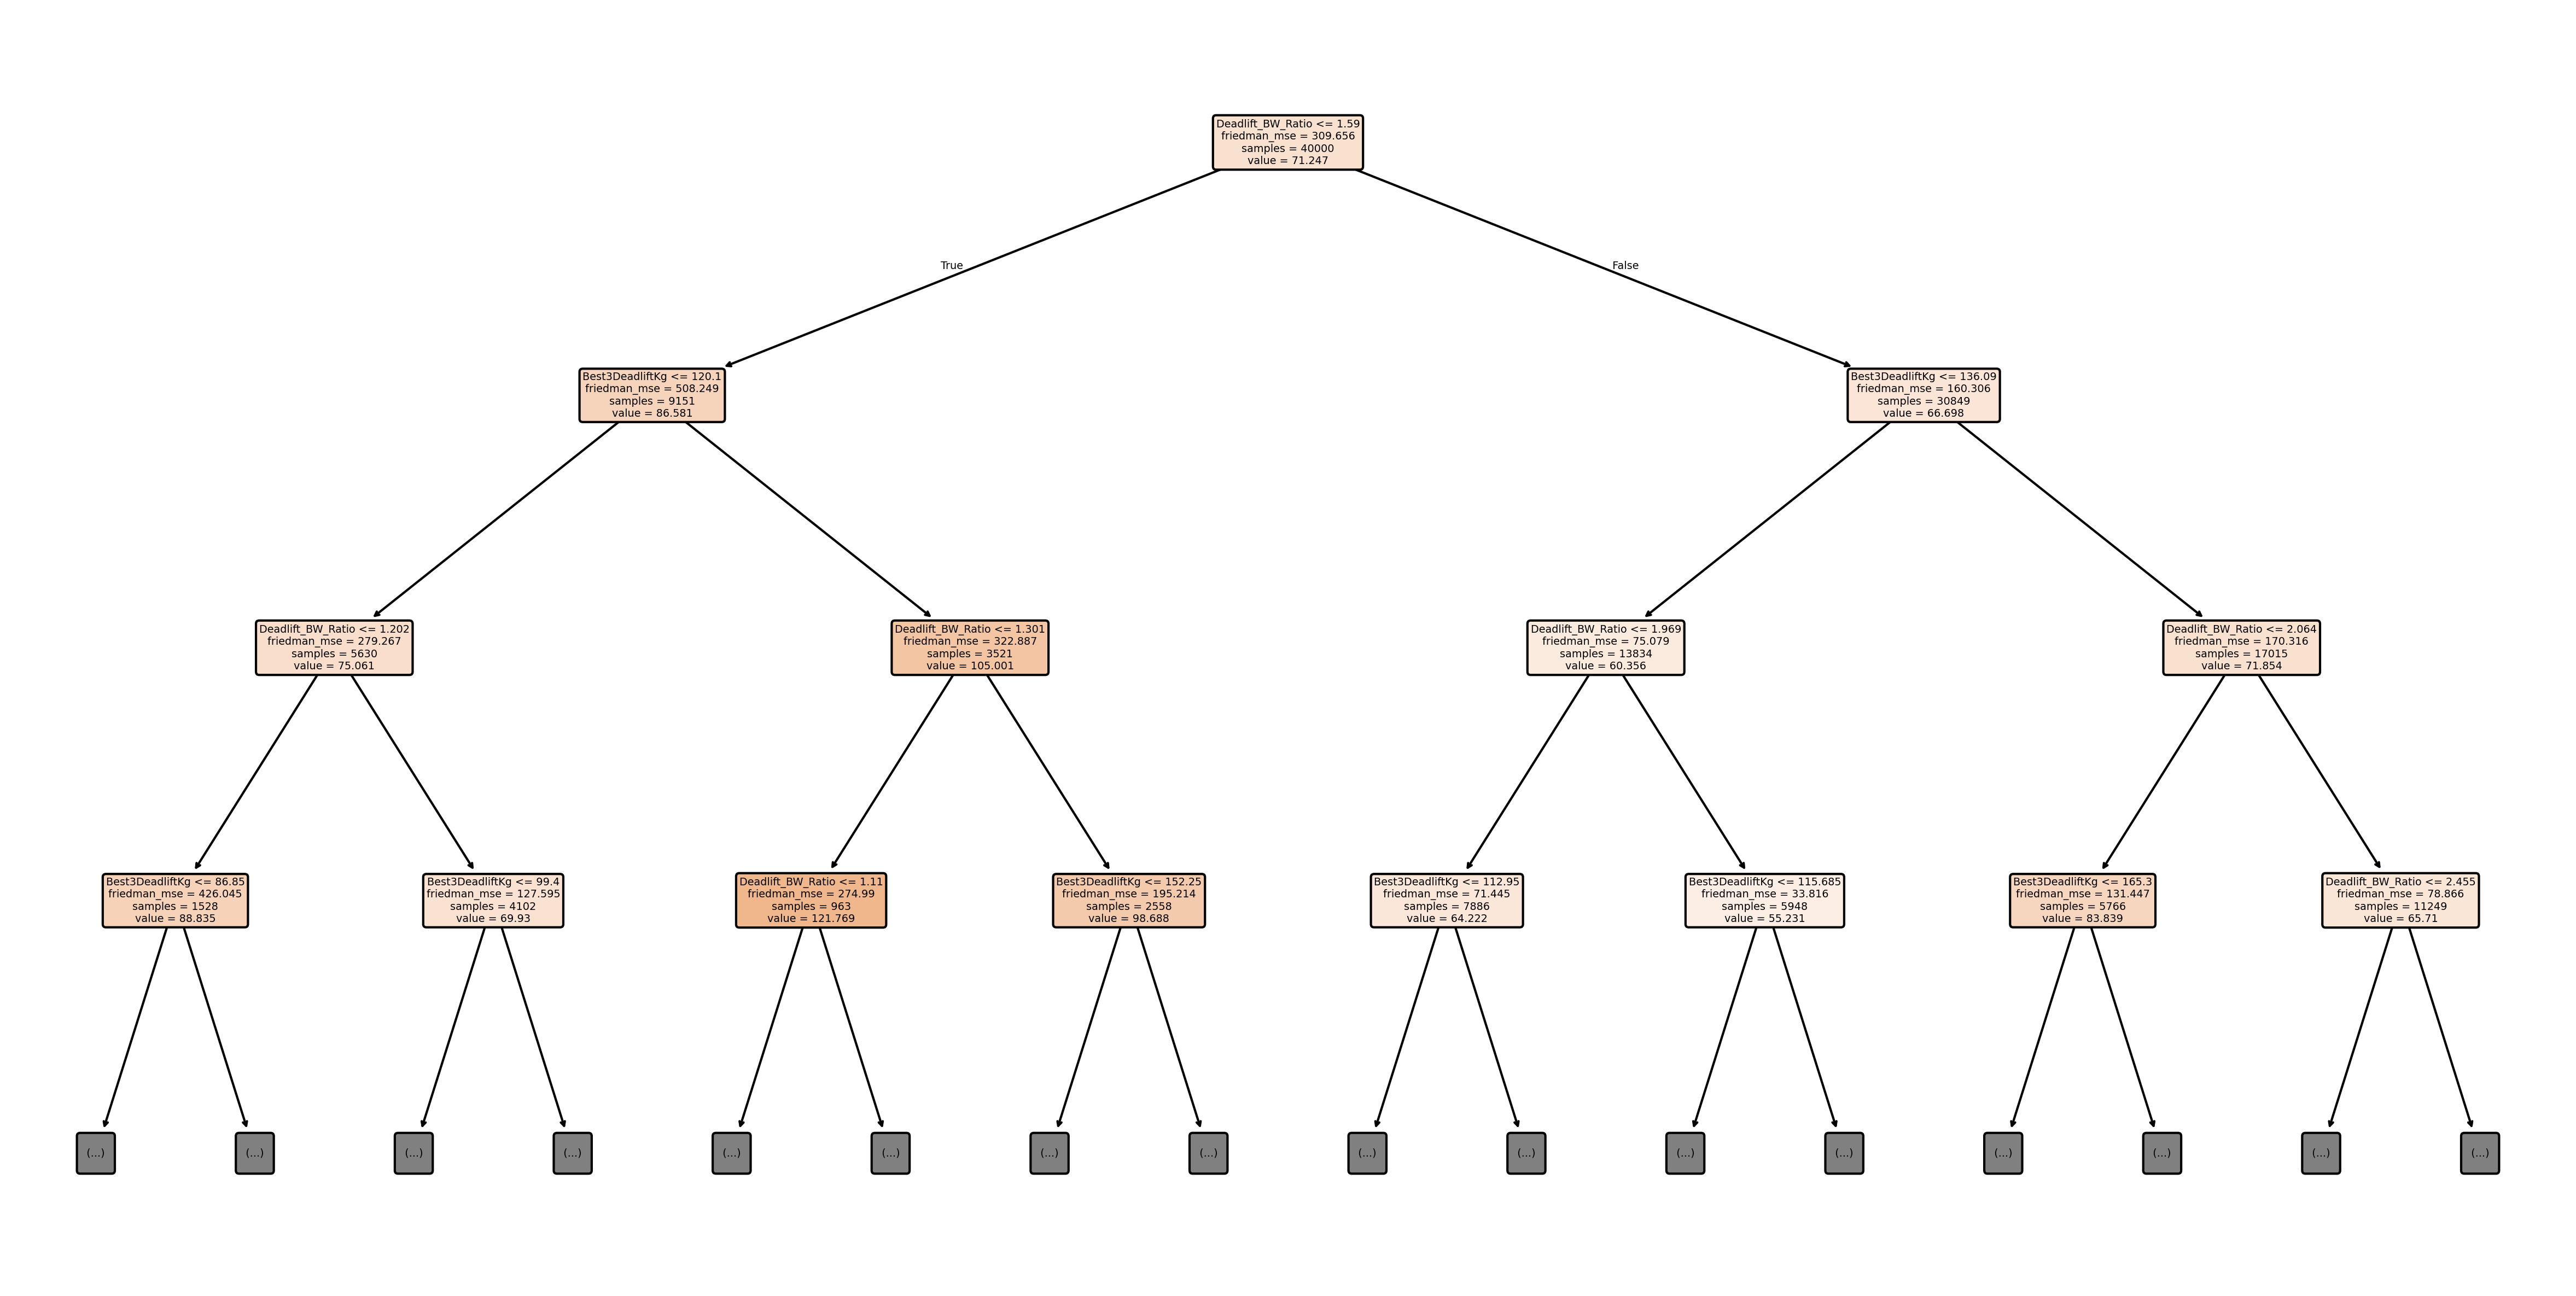

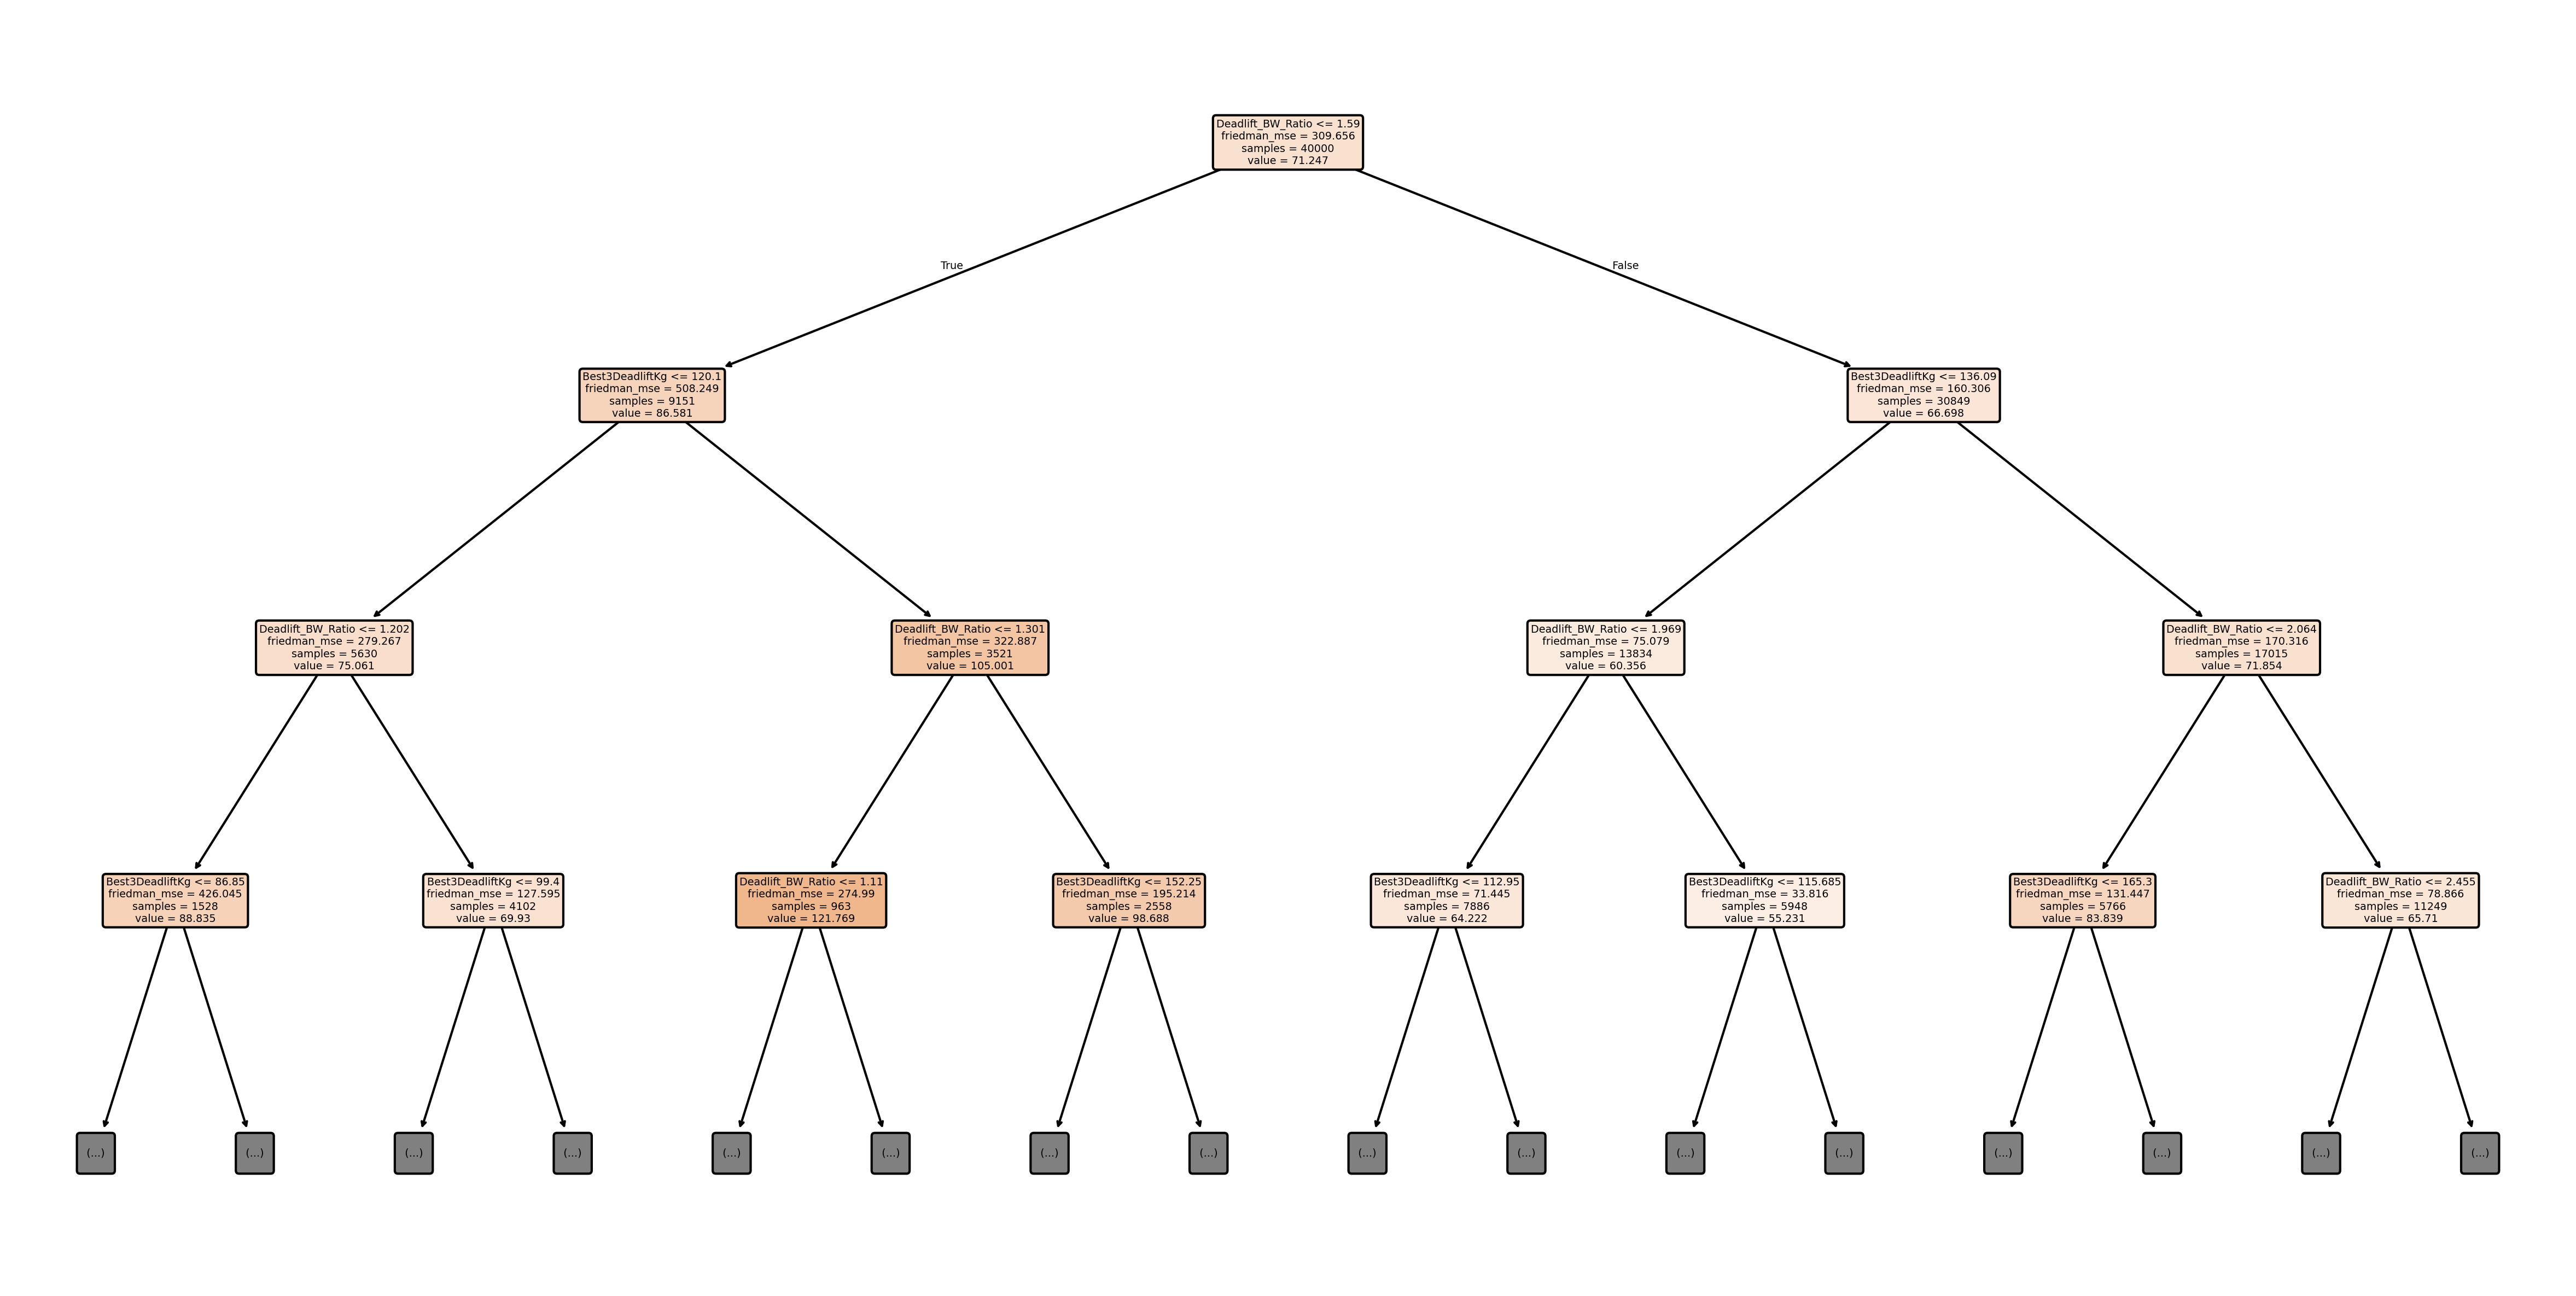

In [13]:
best_tree = DT_grid.best_estimator_
plt.figure(figsize=(20,10))
plot_tree(best_tree, feature_names=X_train.columns, filled=True, rounded=True, max_depth=3)  # can adjust depth for readability
plt.show()
plt.figure(figsize=(20,10))
plot_tree(best_tree, feature_names=X_train.columns, filled=True, rounded=True, max_depth=3)
plt.savefig('dtrees/best_tree_model_female_bodyweight.png', format='png')

In [14]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

models = {
   'Random Forest': RandomForestRegressor(random_state=42, n_jobs = -1, criterion = 'friedman_mse'),
   'Gradient Boosting': GradientBoostingRegressor(random_state=42, criterion = 'friedman_mse'),
   #'XGBoost': xgb.XGBRegressor(random_state=42),
   #'HistGradientBoosting': HistGradientBoostingRegressor(random_state=42),
    'ElasticNet': ElasticNet(random_state=42, max_iter=2000),
   # 'SVR': SVR(verbose=False),
    'Ridge': Ridge(random_state=42),
    'Lasso': Lasso(random_state=42)
}

param_grids = {
    #'Random Forest': {
    #    'n_estimators': [100, 200, 300],
    #    'max_depth': [None],
    #    'min_samples_split': [2],
    #    'min_samples_leaf': [5]
    #},
    'Gradient Boosting': {
        'n_estimators': [100],
        'learning_rate': [0.1, 0.5, 1],
        'max_depth': [20],             
        'min_samples_split': [5],
        'min_samples_leaf': [2],
        'max_features': [None],
    },
    #'XGBoost': {
    #    'n_estimators': [100, 200],
    #    'learning_rate': [0.1, 0.2],
    #    'max_depth': [None]
    #},
    'Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [20],             # None from best DT, plus nearby values
        'min_samples_split': [5],
        'min_samples_leaf': [2],
        'max_features': [None],
        'bootstrap': [True]
    },
    'HistGradientBoosting': {
        'learning_rate': [0.05, 0.1, 0.2],
        'max_iter': [100, 200],
        'max_leaf_nodes': [None],
        'min_samples_leaf': [2],
        'max_depth': [None]
    },
    #'XGBoost': {
    #    'n_estimators': [100, 200, 300],
    #    'learning_rate': [0.05, 0.1, 0.2],
    #    'max_depth': [0],               # drop None for XGB (doesn’t support None)
    #    'subsample': [0.8, 1.0],
    #    'colsample_bytree': [0.8, 1.0],
    #    'min_child_weight': [2, 4],              # aligns with min_samples_leaf from DT
    #    'reg_alpha': [0, 0.1],                   # L1 regularization
    #    'reg_lambda': [1, 5]                     # L2 regularization
    #},
    'ElasticNet': {
        'alpha': [0.1, 1.0, 10.0],
        'l1_ratio': [0.1, 0.5, 0.7, 1.0]
    },
    #'SVR': {
    #    'C': [1, 10],
    #    'gamma': ['scale'],
    #    'kernel': ['rbf']
    #},
    'Ridge' : {
        'alpha': [0.01, 0.1, 1.0, 10.0],
        'max_iter': [10000],
        'solver': ['saga']
    },
    'Lasso' : {
        'alpha': [0.01, 0.1, 1.0, 5, 10],
        'max_iter': [50000]
    }
    
}

best_models = {}
loss_curves = {}

os.makedirs("loss_curves", exist_ok=True)

for model_name, model in models.items():
    print(f"\nTuning {model_name}...")
    clf = GridSearchCV(model, param_grids[model_name], cv=5, n_jobs=-1, scoring='neg_mean_squared_error', return_train_score=True)
    clf.fit(X_scaled, y_train)

    best_model = clf.best_estimator_
    best_models[model_name] = best_model
    print(f"{model_name} Best Parameters: {clf.best_params_}")
    
    # Store loss curve
    loss_df = pd.DataFrame(clf.cv_results_)
    loss_curves[model_name] = -loss_df[['mean_train_score', 'mean_test_score']]  # Make positive MSE

    # Plot and save loss curve
    plt.figure(figsize=(6, 4))
    plt.plot(loss_curves[model_name]['mean_train_score'], label='Train MSE')
    plt.plot(loss_curves[model_name]['mean_test_score'], label='Validation MSE')
    plt.title(f"{model_name} Loss Curve")
    plt.xlabel("Hyperparameter Configurations")
    plt.ylabel("MSE")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Save plot to PNG
    filename = f"loss_curves/{model_name.replace(' ', '_')}_loss_curve_female_bodyweight.png"
    plt.savefig(filename)
    plt.close()  # Closes the figure to avoid displaying all of them inline


Tuning Random Forest...
Random Forest Best Parameters: {'bootstrap': True, 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}

Tuning Gradient Boosting...
Gradient Boosting Best Parameters: {'learning_rate': 0.1, 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}

Tuning ElasticNet...
ElasticNet Best Parameters: {'alpha': 0.1, 'l1_ratio': 1.0}

Tuning Ridge...
Ridge Best Parameters: {'alpha': 0.01, 'max_iter': 10000, 'solver': 'saga'}

Tuning Lasso...
Lasso Best Parameters: {'alpha': 0.01, 'max_iter': 50000}


In [15]:
# Feature importance
print("\nFeature Importances:\n")
for name, model in best_models.items():
    print(f"\n{name}:")

    if hasattr(model, "feature_importances_"):  # Tree-based
        importances = model.feature_importances_
    elif name in ['ElasticNet', 'Ridge', 'Lasso'] and hasattr(model, 'coef_'):
        importances = np.abs(model.coef_)
    else:
        # Fallback to permutation importance
        result = permutation_importance(model, X_scaled, y_train, n_repeats=10, random_state=42, n_jobs=-1)
        importances = result.importances_mean

    for feature, score in sorted(zip(X_train.columns, importances), key=lambda x: x[1], reverse=True)[:10]:
        print(f"{feature}: {score:.4f}")


Feature Importances:


Random Forest:
Deadlift_BW_Ratio: 0.5201
Best3DeadliftKg: 0.4386
TotalKg: 0.0370
Bench_BW_Ratio: 0.0006
Deadlift1Kg: 0.0005
Best3BenchKg: 0.0005
Deadlift2Kg: 0.0004
Goodlift: 0.0004
Deadlift3Kg: 0.0003
Squat_BW_Ratio: 0.0002

Gradient Boosting:
Deadlift_BW_Ratio: 0.5194
Best3DeadliftKg: 0.4779
Best3BenchKg: 0.0004
Bench_BW_Ratio: 0.0003
Squat1Kg: 0.0002
Deadlift2Kg: 0.0002
Squat_BW_Ratio: 0.0002
Deadlift1Kg: 0.0001
Bench2Kg: 0.0001
Deadlift3Kg: 0.0001

ElasticNet:
Deadlift_BW_Ratio: 18.7471
Wilks: 12.7517
Squat_BW_Ratio: 9.1600
Best3DeadliftKg: 8.2700
Goodlift: 6.9518
Bench_BW_Ratio: 5.2283
Age: 0.1848
Bench_Total_Ratio: 0.1829
Squat1Kg: 0.0350
Best3BenchKg: 0.0009

Ridge:
Dots: 40.0993
Deadlift_BW_Ratio: 35.5021
Wilks: 24.5182
Best3SquatKg: 17.3159
Bench_BW_Ratio: 14.1362
Squat_BW_Ratio: 12.6639
Best3DeadliftKg: 9.5153
TotalKg: 3.9694
Best3BenchKg: 2.3197
Deadlift_Total_Ratio: 1.6375

Lasso:
Wilks: 32.5476
Deadlift_BW_Ratio: 27.6125
Best3DeadliftKg: 11.3523
Bes

In [16]:
# Predict on Test Dataset and Performance
# Dictionary to store test results
test_results = {}
X_test_scaled = scaler.transform(X_test)
# Predict and evaluate
for name, model in best_models.items():
    y_pred = model.predict(X_test_scaled)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    test_results[name] = {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    }
#    print(f"{name} Performance:")
#    print(f"  RMSE: {rmse:.4f}")
#    print(f"  MAE : {mae:.4f}")
#    print(f"  R²  : {r2:.4f}\n")
pd.DataFrame(test_results).T.sort_values(by="RMSE")

RMSE       MAE        R2
Random Forest      0.647413  0.145691  0.998709
Gradient Boosting  0.797325  0.196919  0.998042
Ridge              3.594492  2.161128  0.960202
Lasso              3.633089  2.155127  0.959342
ElasticNet         4.118207  2.480554  0.947760

# Predicting Age from all other features

### Male

In [17]:
USA_Male_Powerlifter_data_no_age = USA_Male_Powerlifter_data.drop(columns='Age').sample(50000, random_state = 42)
male_ages = USA_Male_Powerlifter_data['Age'].sample(50000, random_state = 42)
USA_Male_Powerlifter_data_no_age.head(5)


BodyweightKg  Squat1Kg  Squat2Kg  Squat3Kg  Best3SquatKg  Bench1Kg  \
74908          72.18      42.5     -62.5      67.5          67.5      70.0   
112611         97.60     207.5     217.5     230.0         230.0     112.5   
80245          80.65     170.0     180.0     190.0         190.0     122.5   
66158          71.65     170.0     182.5     185.0         185.0     105.0   
118633         89.00     162.5    -172.5     172.5         172.5     110.0   

        Bench2Kg  Bench3Kg  Best3BenchKg  Deadlift1Kg  ...  Bench3Success  \
74908      -80.0     -80.0          70.0        137.5  ...              0   
112611     117.5    -122.5         117.5        242.5  ...              0   
80245      127.5    -130.0         127.5        197.5  ...              0   
66158      112.5     117.5         117.5        215.0  ...              1   
118633     115.0     117.5         117.5        182.5  ...              1   

        Deadlift1Success  Deadlift2Success  Deadlift3Success  Squat_BW_Ratio  \
74908                  1                 1                 1        0.935162   
112611                 1                 1                 0        2.356557   
80245                  1                 1                 0        2.355859   
66158                  1                 1                 1        2.581996   
118633                 1                 1                 1        1.938202   

        Bench_BW_Ratio  Deadlift_BW_Ratio  Squat_Total_Ratio  \
74908         0.969798           2.008867           0.238938   
112611        1.203893           2.638320           0.380165   
80245         1.580905           2.603844           0.360190   
66158         1.639916           3.279833           0.344186   
118633        1.320225           2.247191           0.352041   

        Bench_Total_Ratio  Deadlift_Total_Ratio  
74908            0.247788              0.513274  
112611           0.194215              0.425620  
80245            0.241706              0.398104  
66158            0.218605              0.437209  
118633           0.239796              0.408163  

[5 rows x 33 columns]

In [18]:
X_train, X_test, y_train, y_test = train_test_split(USA_Male_Powerlifter_data_no_age, male_ages, test_size=0.20, random_state=42)
DT_parameters = {'max_depth':(None, 1, 3, 5, 10, 20, 30), 'min_samples_split':(2, 5, 10, 20, 50), 'min_samples_leaf': (1, 2, 5, 10, 15, 25), }
DT_cv = DecisionTreeRegressor(random_state = 42, criterion='friedman_mse')
DT_grid = GridSearchCV(estimator = DT_cv, param_grid = DT_parameters, n_jobs = -1, scoring='neg_mean_squared_error')
DT_grid.fit(X_train, y_train)
DT_grid.best_estimator_.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'max_depth': 5,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 25,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 42,
 'splitter': 'best'}

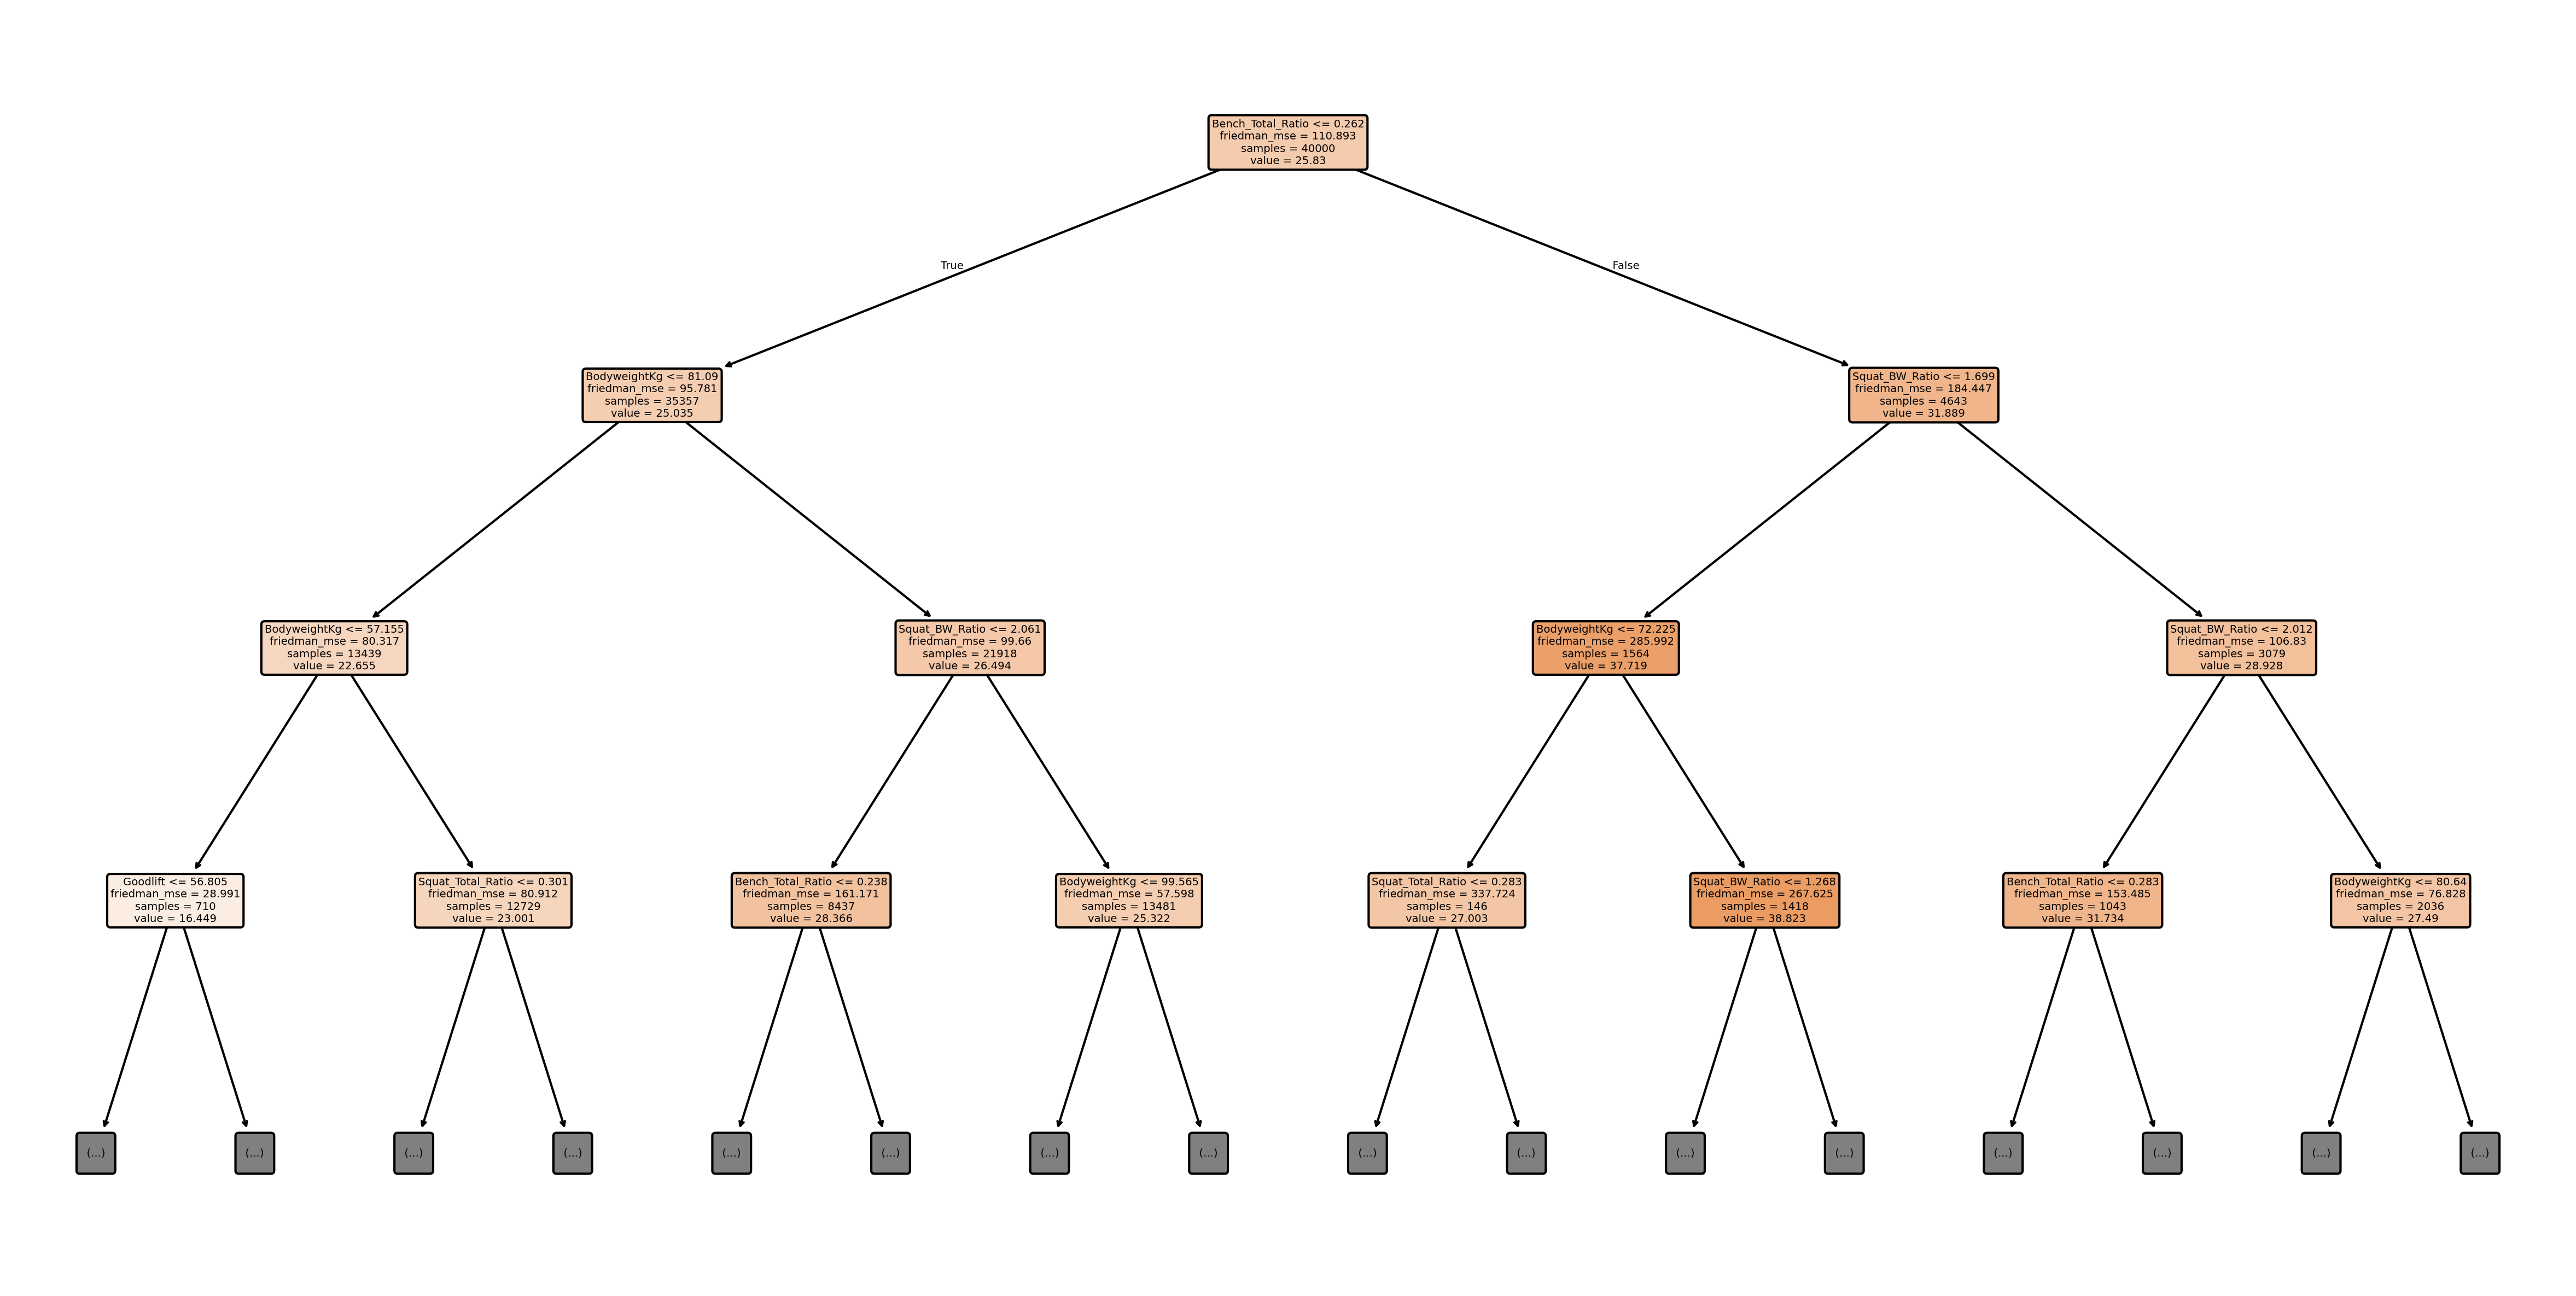

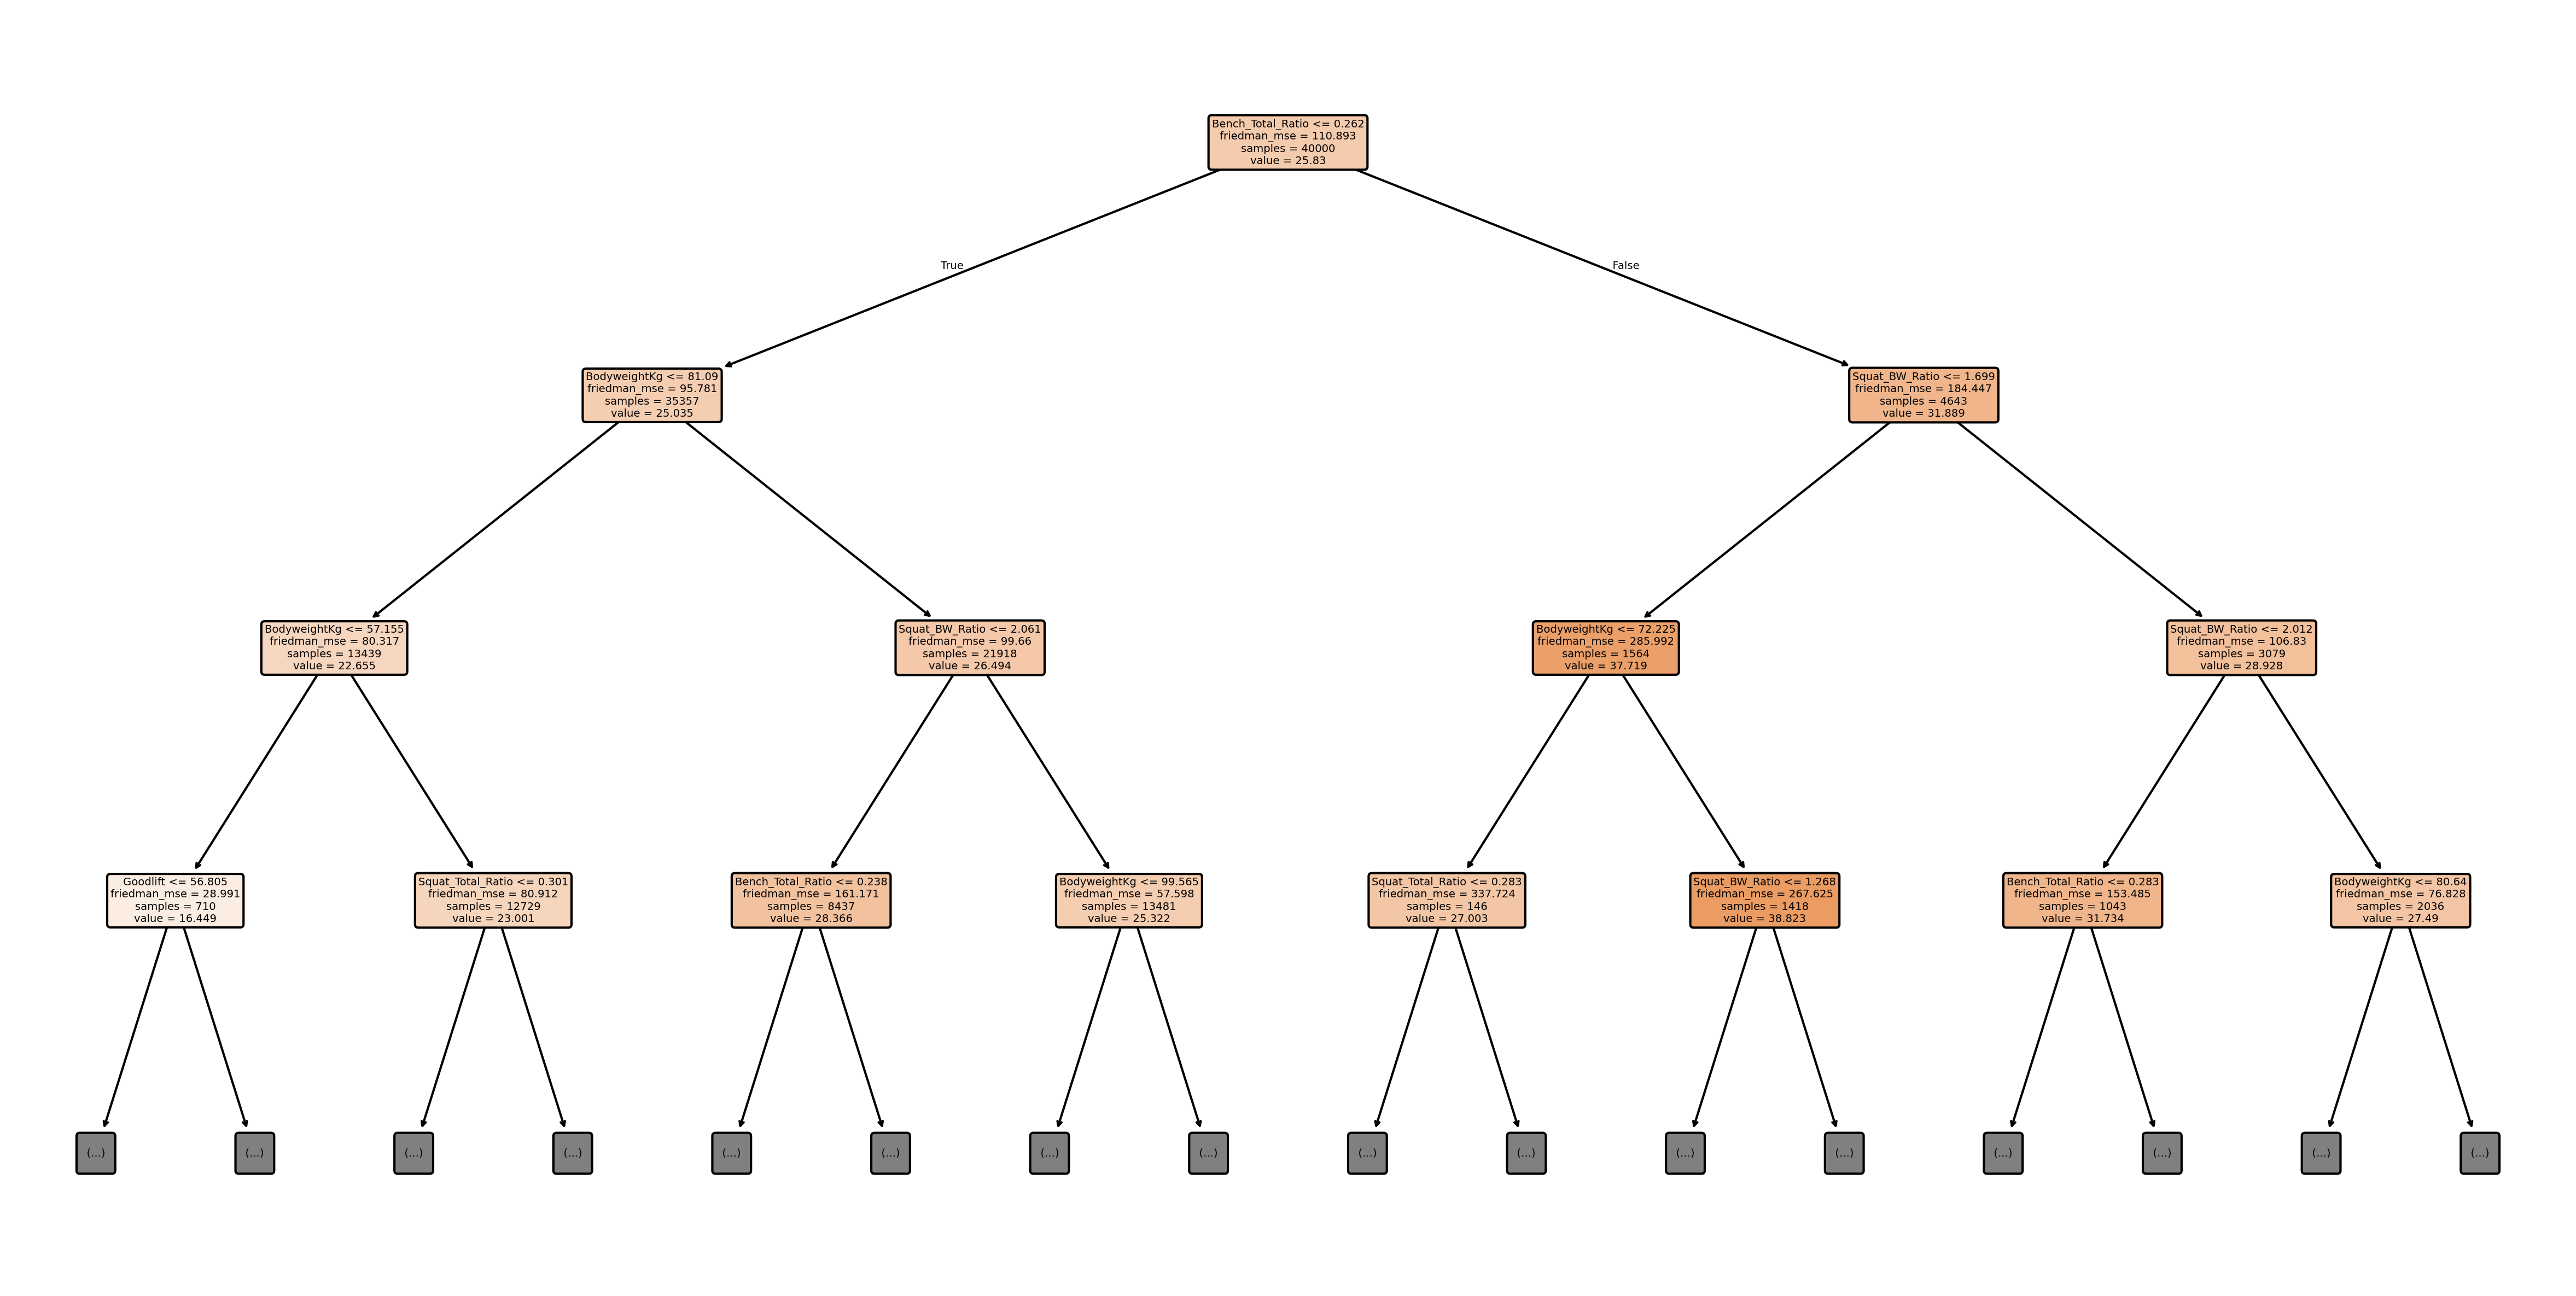

In [19]:
best_tree = DT_grid.best_estimator_
plt.figure(figsize=(20,10))
plot_tree(best_tree, feature_names=X_train.columns, filled=True, rounded=True, max_depth=3)  # can adjust depth for readability
plt.show()
plt.figure(figsize=(20,10))
plot_tree(best_tree, feature_names=X_train.columns, filled=True, rounded=True, max_depth=3)
plt.savefig('dtrees/best_tree_model_male_age.png', format='png')

In [20]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

models = {
   'Random Forest': RandomForestRegressor(random_state=42, n_jobs = -1, criterion = 'friedman_mse'),
   'Gradient Boosting': GradientBoostingRegressor(random_state=42, criterion = 'friedman_mse'),
   #'XGBoost': xgb.XGBRegressor(random_state=42),
   #'HistGradientBoosting': HistGradientBoostingRegressor(random_state=42),
    'ElasticNet': ElasticNet(random_state=42, max_iter=2000),
   # 'SVR': SVR(verbose=False),
    'Ridge': Ridge(random_state=42),
    'Lasso': Lasso(random_state=42)
}

param_grids = {
    #'Random Forest': {
    #    'n_estimators': [100, 200, 300],
    #    'max_depth': [None],
    #    'min_samples_split': [2],
    #    'min_samples_leaf': [5]
    #},
    'Gradient Boosting': {
        'n_estimators': [100],
        'learning_rate': [0.1, 0.5, 1],
        'max_depth': [20],             
        'min_samples_split': [5],
        'min_samples_leaf': [2],
        'max_features': [None],
    },
    #'XGBoost': {
    #    'n_estimators': [100, 200],
    #    'learning_rate': [0.1, 0.2],
    #    'max_depth': [None]
    #},
    'Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [20],             # None from best DT, plus nearby values
        'min_samples_split': [5],
        'min_samples_leaf': [2],
        'max_features': [None],
        'bootstrap': [True]
    },
    'HistGradientBoosting': {
        'learning_rate': [0.05, 0.1, 0.2],
        'max_iter': [100, 200],
        'max_leaf_nodes': [None],
        'min_samples_leaf': [2],
        'max_depth': [None]
    },
    #'XGBoost': {
    #    'n_estimators': [100, 200, 300],
    #    'learning_rate': [0.05, 0.1, 0.2],
    #    'max_depth': [0],               # drop None for XGB (doesn’t support None)
    #    'subsample': [0.8, 1.0],
    #    'colsample_bytree': [0.8, 1.0],
    #    'min_child_weight': [2, 4],              # aligns with min_samples_leaf from DT
    #    'reg_alpha': [0, 0.1],                   # L1 regularization
    #    'reg_lambda': [1, 5]                     # L2 regularization
    #},
    'ElasticNet': {
        'alpha': [0.1, 1.0, 10.0],
        'l1_ratio': [0.1, 0.5, 0.7, 1.0]
    },
    #'SVR': {
    #    'C': [1, 10],
    #    'gamma': ['scale'],
    #    'kernel': ['rbf']
    #},
    'Ridge' : {
        'alpha': [0.01, 0.1, 1.0, 10.0],
        'max_iter': [10000],
        'solver': ['saga']
    },
    'Lasso' : {
        'alpha': [0.01, 0.1, 1.0, 5, 10],
        'max_iter': [50000]
    }
    
}

best_models = {}
loss_curves = {}

os.makedirs("loss_curves", exist_ok=True)

for model_name, model in models.items():
    print(f"\nTuning {model_name}...")
    clf = GridSearchCV(model, param_grids[model_name], cv=5, n_jobs=-1, scoring='neg_mean_squared_error', return_train_score=True)
    clf.fit(X_scaled, y_train)

    best_model = clf.best_estimator_
    best_models[model_name] = best_model
    print(f"{model_name} Best Parameters: {clf.best_params_}")
    
    # Store loss curve
    loss_df = pd.DataFrame(clf.cv_results_)
    loss_curves[model_name] = -loss_df[['mean_train_score', 'mean_test_score']]  # Make positive MSE

    # Plot and save loss curve
    plt.figure(figsize=(6, 4))
    plt.plot(loss_curves[model_name]['mean_train_score'], label='Train MSE')
    plt.plot(loss_curves[model_name]['mean_test_score'], label='Validation MSE')
    plt.title(f"{model_name} Loss Curve")
    plt.xlabel("Hyperparameter Configurations")
    plt.ylabel("MSE")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Save plot to PNG
    filename = f"loss_curves/{model_name.replace(' ', '_')}_loss_curve_male_age.png"
    plt.savefig(filename)
    plt.close()  # Closes the figure to avoid displaying all of them inline


Tuning Random Forest...
Random Forest Best Parameters: {'bootstrap': True, 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}

Tuning Gradient Boosting...
Gradient Boosting Best Parameters: {'learning_rate': 0.1, 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}

Tuning ElasticNet...
ElasticNet Best Parameters: {'alpha': 0.1, 'l1_ratio': 0.1}

Tuning Ridge...
Ridge Best Parameters: {'alpha': 0.01, 'max_iter': 10000, 'solver': 'saga'}

Tuning Lasso...
Lasso Best Parameters: {'alpha': 0.01, 'max_iter': 50000}


In [21]:
# Feature importance
print("\nFeature Importances:\n")
for name, model in best_models.items():
    print(f"\n{name}:")

    if hasattr(model, "feature_importances_"):  # Tree-based
        importances = model.feature_importances_
    elif name in ['ElasticNet', 'Ridge', 'Lasso'] and hasattr(model, 'coef_'):
        importances = np.abs(model.coef_)
    else:
        # Fallback to permutation importance
        result = permutation_importance(model, X_scaled, y_train, n_repeats=10, random_state=42, n_jobs=-1)
        importances = result.importances_mean

    for feature, score in sorted(zip(X_train.columns, importances), key=lambda x: x[1], reverse=True)[:10]:
        print(f"{feature}: {score:.4f}")


Feature Importances:


Random Forest:
Bench_Total_Ratio: 0.1249
BodyweightKg: 0.1149
Squat_BW_Ratio: 0.0975
Squat_Total_Ratio: 0.0708
Bench_BW_Ratio: 0.0481
Deadlift_BW_Ratio: 0.0475
Deadlift_Total_Ratio: 0.0467
Squat1Kg: 0.0326
Deadlift1Kg: 0.0317
Bench1Kg: 0.0301

Gradient Boosting:
Bench_Total_Ratio: 0.1144
BodyweightKg: 0.1068
Squat_BW_Ratio: 0.0893
Squat_Total_Ratio: 0.0694
Bench_BW_Ratio: 0.0574
Deadlift_BW_Ratio: 0.0488
Deadlift_Total_Ratio: 0.0468
Squat1Kg: 0.0363
Deadlift1Kg: 0.0332
Bench1Kg: 0.0324

ElasticNet:
Bench_Total_Ratio: 1.4949
Squat_Total_Ratio: 1.3969
BodyweightKg: 1.3949
Glossbrenner: 0.6135
Best3DeadliftKg: 0.5452
Wilks: 0.5408
Bench2Success: 0.4231
Best3BenchKg: 0.3831
Deadlift1Kg: 0.3804
Bench3Success: 0.3560

Ridge:
Wilks: 35.8046
Dots: 26.6115
Glossbrenner: 8.7806
Goodlift: 6.9004
BodyweightKg: 4.8835
Squat_BW_Ratio: 4.8652
Squat_Total_Ratio: 4.1631
Deadlift_BW_Ratio: 3.4399
Bench_BW_Ratio: 1.9425
Deadlift_Total_Ratio: 1.6460

Lasso:
Wilks: 6.4864
Squat_BW_R

In [22]:
# Predict on Test Dataset and Performance
# Dictionary to store test results
test_results = {}
X_test_scaled = scaler.transform(X_test)
# Predict and evaluate
for name, model in best_models.items():
    y_pred = model.predict(X_test_scaled)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    test_results[name] = {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    }
#    print(f"{name} Performance:")
#    print(f"  RMSE: {rmse:.4f}")
#    print(f"  MAE : {mae:.4f}")
#    print(f"  R²  : {r2:.4f}\n")
pd.DataFrame(test_results).T.sort_values(by="RMSE")

RMSE       MAE        R2
Random Forest      9.355220  6.435853  0.204995
Ridge              9.750324  6.730170  0.136425
Lasso              9.768959  6.746087  0.133121
ElasticNet         9.831169  6.815388  0.122045
Gradient Boosting  9.858076  6.563467  0.117233

### Female

In [23]:
USA_Female_Powerlifter_data_no_age = USA_Female_Powerlifter_data.drop(columns='Age').sample(50000, random_state = 42)
female_ages = USA_Female_Powerlifter_data['Age'].sample(50000, random_state = 42)
USA_Female_Powerlifter_data_no_age.head(5)

BodyweightKg  Squat1Kg  Squat2Kg  Squat3Kg  Best3SquatKg  Bench1Kg  \
51060          55.8      65.0      70.0      80.0          80.0      35.0   
27622          67.5     137.5     147.5     155.0         155.0      82.5   
32677          54.0     100.0     105.0    -110.0         105.0      52.5   
15056          83.4     132.5     140.0     142.5         142.5      85.0   
36063          74.1      72.5      85.0      95.0          95.0      42.5   

       Bench2Kg  Bench3Kg  Best3BenchKg  Deadlift1Kg  ...  Bench3Success  \
51060      40.0      42.5          42.5        105.0  ...              1   
27622      87.5      92.5          92.5        155.0  ...              1   
32677     -55.0     -55.0          52.5        137.5  ...              0   
15056      90.0      95.0          95.0       -175.0  ...              1   
36063      47.5     -50.0          47.5         87.5  ...              0   

       Deadlift1Success  Deadlift2Success  Deadlift3Success  Squat_BW_Ratio  \
51060                 1                 1                 1        1.433692   
27622                 1                 1                 0        2.296296   
32677                 1                 1                 1        1.944444   
15056                 0                 1                 1        1.708633   
36063                 1                 1                 0        1.282051   

       Bench_BW_Ratio  Deadlift_BW_Ratio  Squat_Total_Ratio  \
51060        0.761649           2.195341           0.326531   
27622        1.370370           2.444444           0.375758   
32677        0.972222           2.731481           0.344262   
15056        1.139089           2.188249           0.339286   
36063        0.641026           1.349528           0.391753   

       Bench_Total_Ratio  Deadlift_Total_Ratio  
51060           0.173469              0.500000  
27622           0.224242              0.400000  
32677           0.172131              0.483607  
15056           0.226190              0.434524  
36063           0.195876              0.412371  

[5 rows x 33 columns]

In [24]:
X_train, X_test, y_train, y_test = train_test_split(USA_Female_Powerlifter_data_no_age, female_ages, test_size=0.20, random_state=42)
DT_parameters = {'max_depth':(None, 1, 3, 5, 10, 20, 30), 'min_samples_split':(2, 5, 10, 20, 50), 'min_samples_leaf': (1, 2, 5, 10, 15, 25), }
DT_cv = DecisionTreeRegressor(random_state = 42, criterion='friedman_mse')
DT_grid = GridSearchCV(estimator = DT_cv, param_grid = DT_parameters, n_jobs = -1, scoring='neg_mean_squared_error')
DT_grid.fit(X_train, y_train)
DT_grid.best_estimator_.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'max_depth': 5,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 42,
 'splitter': 'best'}

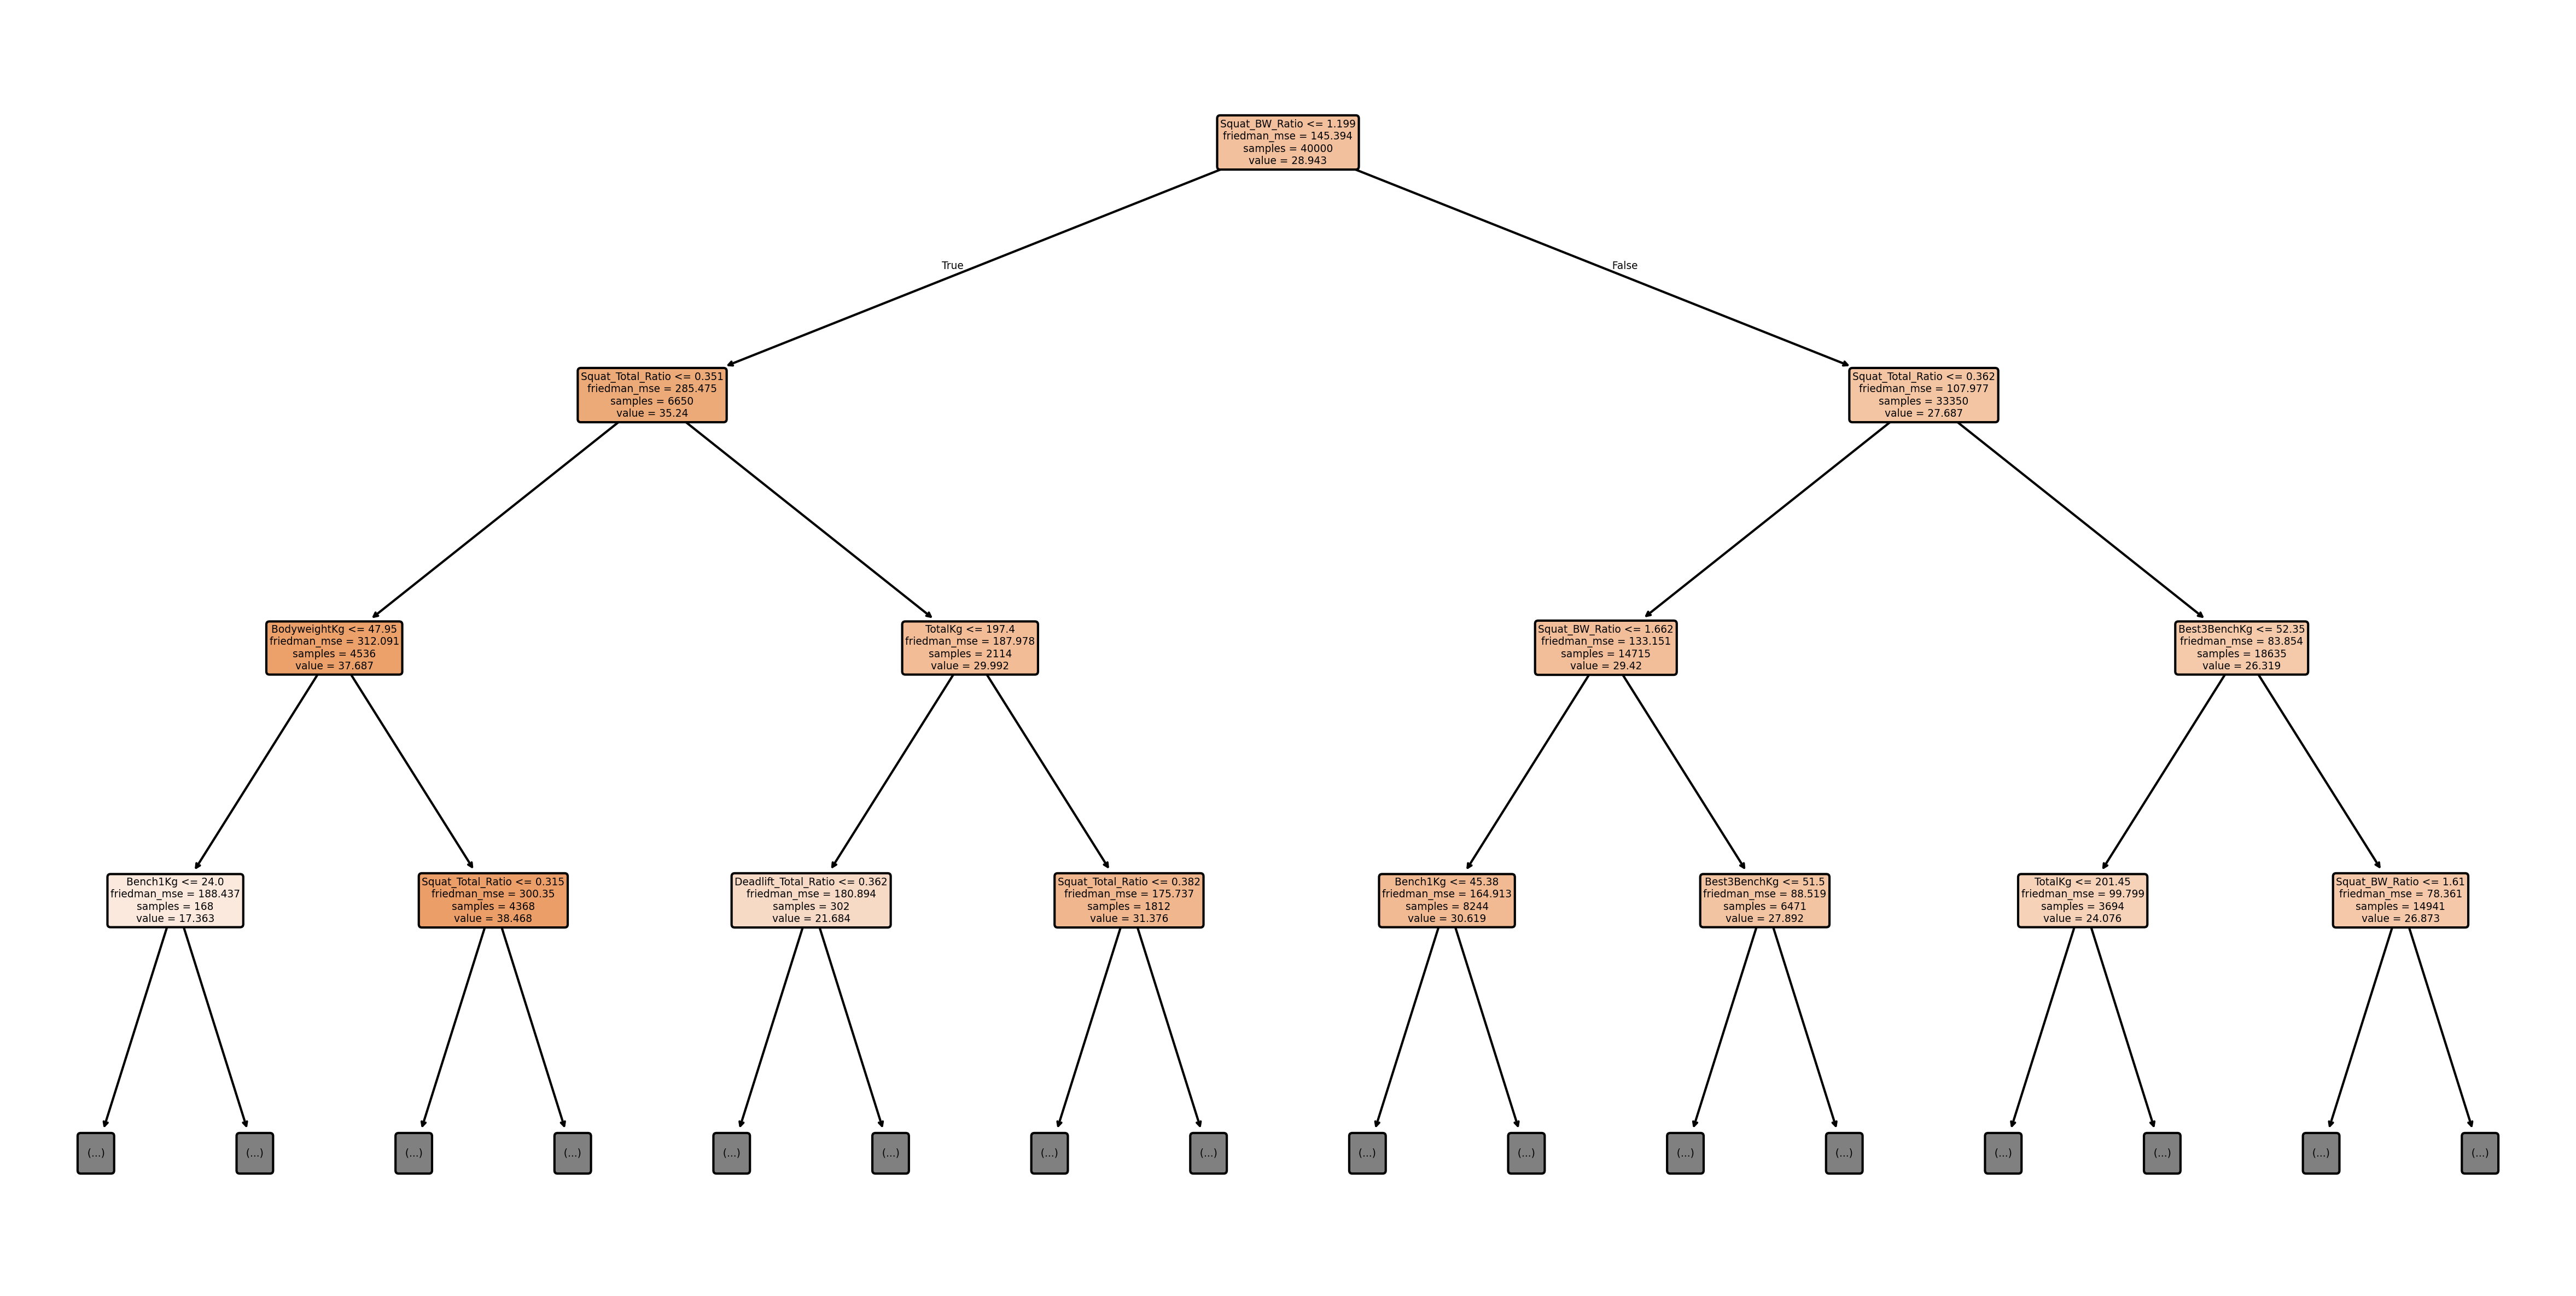

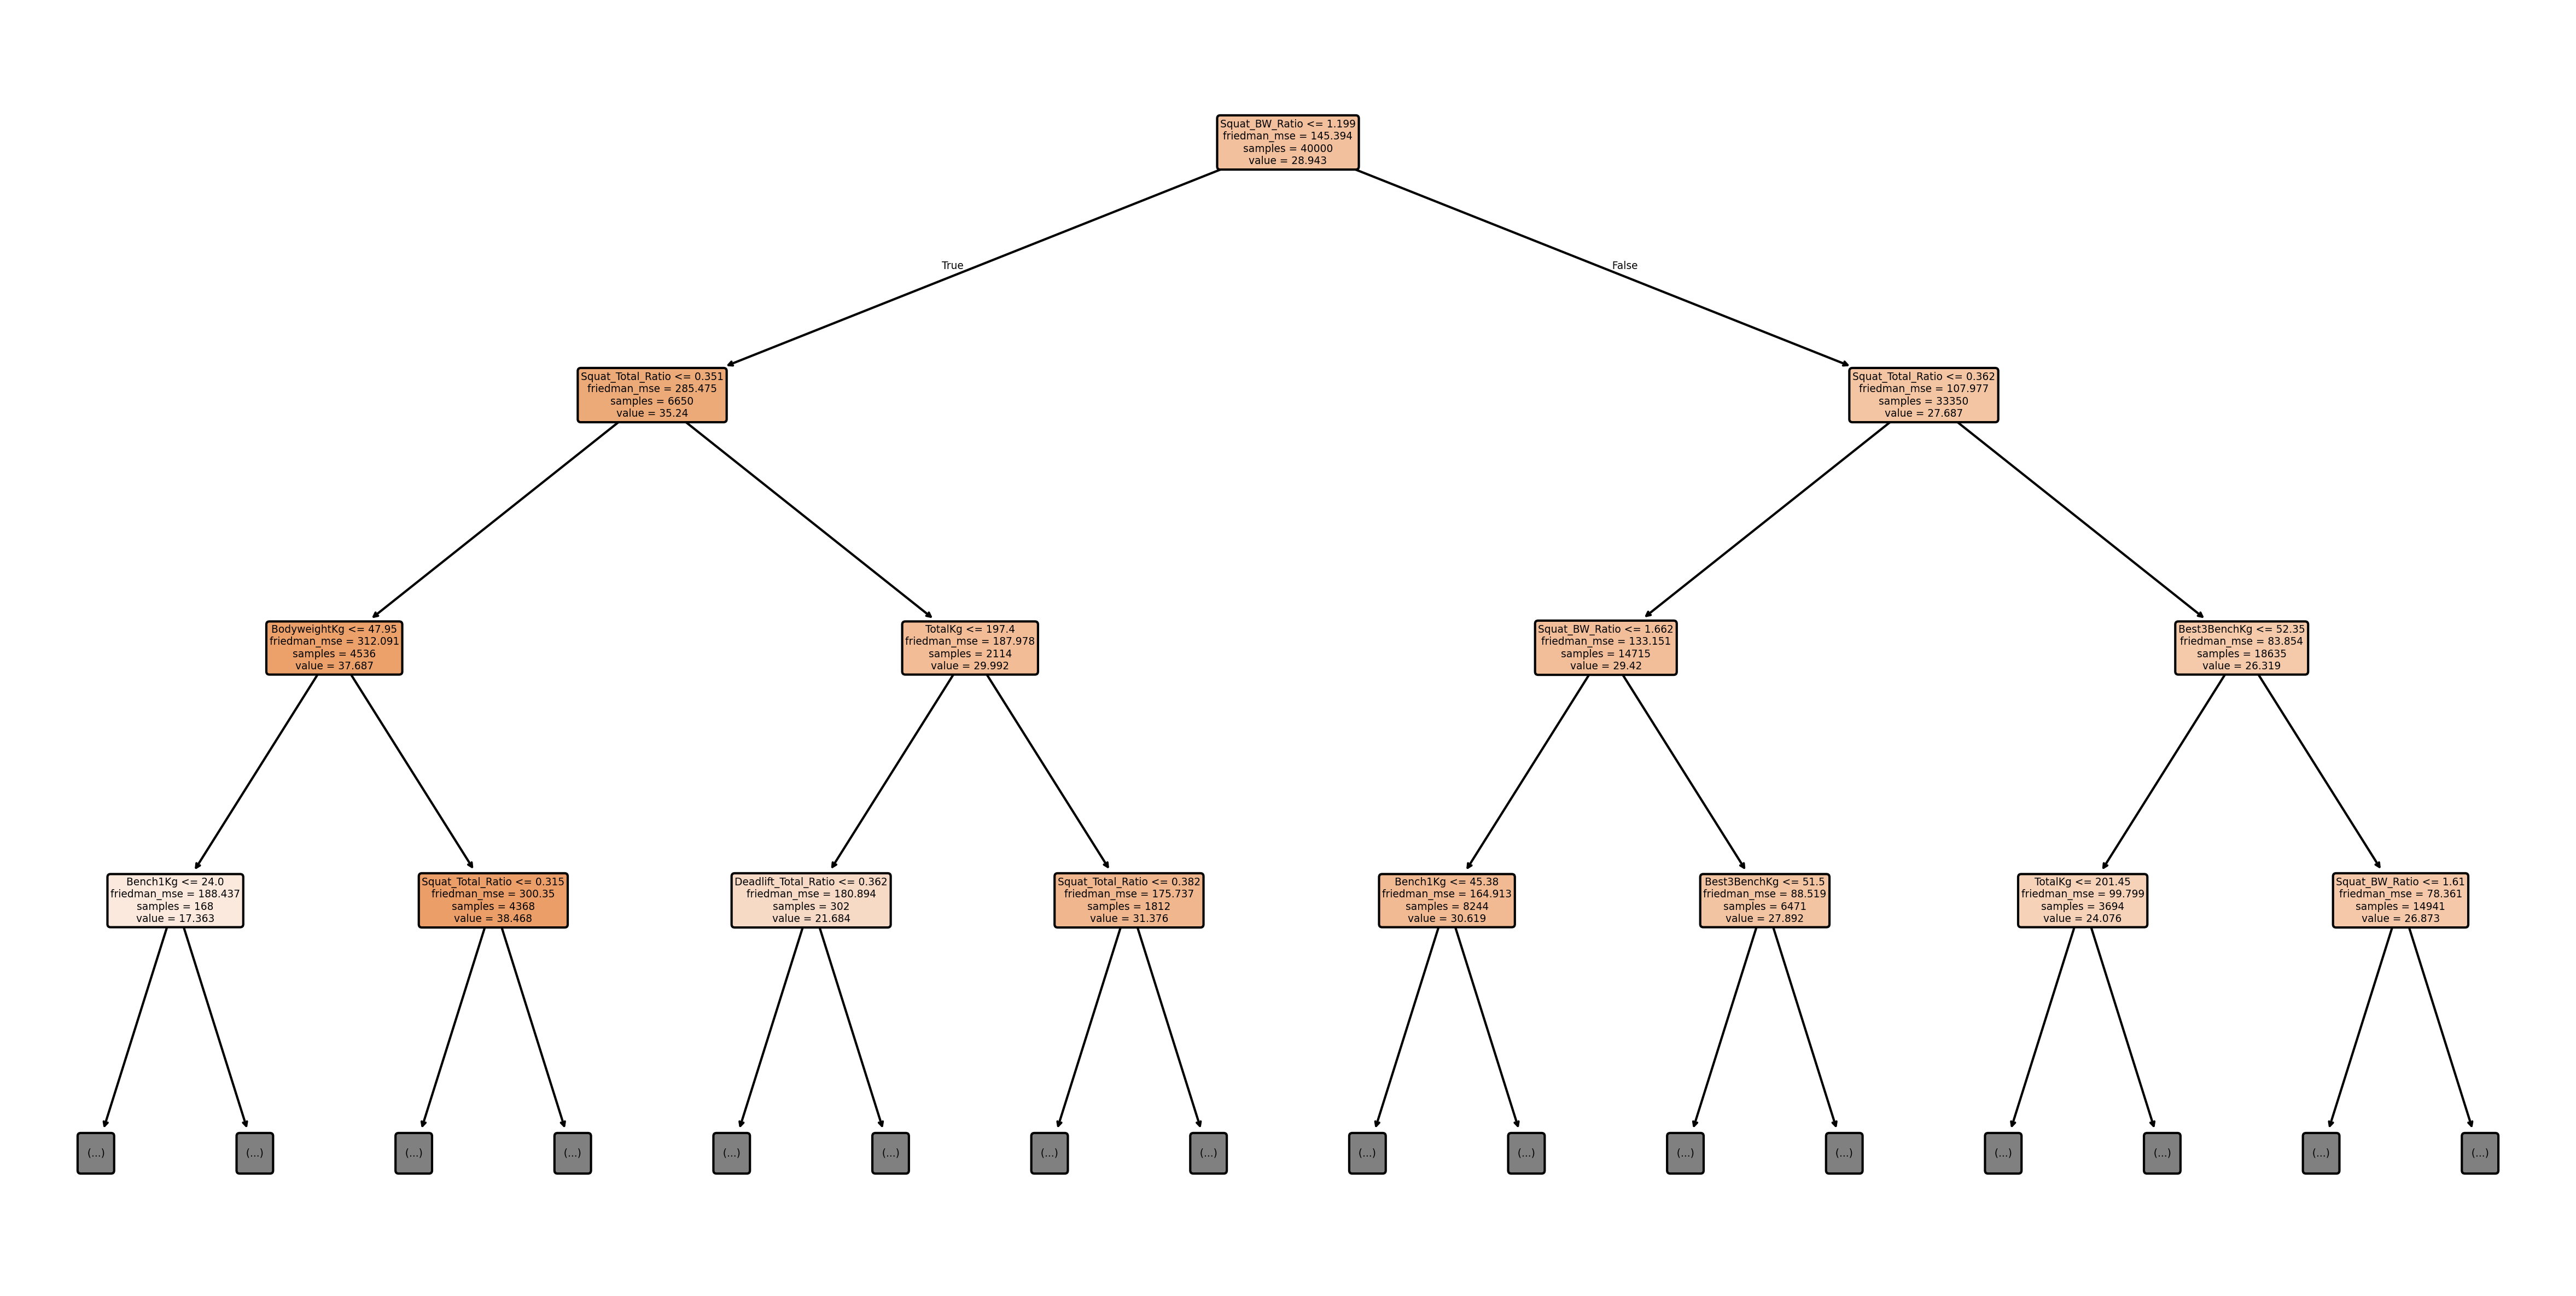

In [25]:
best_tree = DT_grid.best_estimator_
plt.figure(figsize=(20,10))
plot_tree(best_tree, feature_names=X_train.columns, filled=True, rounded=True, max_depth=3)  # can adjust depth for readability
plt.show()
plt.figure(figsize=(20,10))
plot_tree(best_tree, feature_names=X_train.columns, filled=True, rounded=True, max_depth=3)
plt.savefig('dtrees/best_tree_model_female_age.png', format='png')

In [26]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

models = {
   'Random Forest': RandomForestRegressor(random_state=42, n_jobs = -1, criterion = 'friedman_mse'),
   'Gradient Boosting': GradientBoostingRegressor(random_state=42, criterion = 'friedman_mse'),
   #'XGBoost': xgb.XGBRegressor(random_state=42),
   #'HistGradientBoosting': HistGradientBoostingRegressor(random_state=42),
    'ElasticNet': ElasticNet(random_state=42, max_iter=2000),
   # 'SVR': SVR(verbose=False),
    'Ridge': Ridge(random_state=42),
    'Lasso': Lasso(random_state=42)
}

param_grids = {
    #'Random Forest': {
    #    'n_estimators': [100, 200, 300],
    #    'max_depth': [None],
    #    'min_samples_split': [2],
    #    'min_samples_leaf': [5]
    #},
    'Gradient Boosting': {
        'n_estimators': [100],
        'learning_rate': [0.1, 0.5, 1],
        'max_depth': [20],             
        'min_samples_split': [5],
        'min_samples_leaf': [2],
        'max_features': [None],
    },
    #'XGBoost': {
    #    'n_estimators': [100, 200],
    #    'learning_rate': [0.1, 0.2],
    #    'max_depth': [None]
    #},
    'Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [20],             # None from best DT, plus nearby values
        'min_samples_split': [5],
        'min_samples_leaf': [2],
        'max_features': [None],
        'bootstrap': [True]
    },
    'HistGradientBoosting': {
        'learning_rate': [0.05, 0.1, 0.2],
        'max_iter': [100, 200],
        'max_leaf_nodes': [None],
        'min_samples_leaf': [2],
        'max_depth': [None]
    },
    #'XGBoost': {
    #    'n_estimators': [100, 200, 300],
    #    'learning_rate': [0.05, 0.1, 0.2],
    #    'max_depth': [0],               # drop None for XGB (doesn’t support None)
    #    'subsample': [0.8, 1.0],
    #    'colsample_bytree': [0.8, 1.0],
    #    'min_child_weight': [2, 4],              # aligns with min_samples_leaf from DT
    #    'reg_alpha': [0, 0.1],                   # L1 regularization
    #    'reg_lambda': [1, 5]                     # L2 regularization
    #},
    'ElasticNet': {
        'alpha': [0.1, 1.0, 10.0],
        'l1_ratio': [0.1, 0.5, 0.7, 1.0]
    },
    #'SVR': {
    #    'C': [1, 10],
    #    'gamma': ['scale'],
    #    'kernel': ['rbf']
    #},
    'Ridge' : {
        'alpha': [0.01, 0.1, 1.0, 10.0],
        'max_iter': [10000],
        'solver': ['saga']
    },
    'Lasso' : {
        'alpha': [0.01, 0.1, 1.0, 5, 10],
        'max_iter': [50000]
    }
    
}

best_models = {}
loss_curves = {}

os.makedirs("loss_curves", exist_ok=True)

for model_name, model in models.items():
    print(f"\nTuning {model_name}...")
    clf = GridSearchCV(model, param_grids[model_name], cv=5, n_jobs=-1, scoring='neg_mean_squared_error', return_train_score=True)
    clf.fit(X_scaled, y_train)

    best_model = clf.best_estimator_
    best_models[model_name] = best_model
    print(f"{model_name} Best Parameters: {clf.best_params_}")
    
    # Store loss curve
    loss_df = pd.DataFrame(clf.cv_results_)
    loss_curves[model_name] = -loss_df[['mean_train_score', 'mean_test_score']]  # Make positive MSE

    # Plot and save loss curve
    plt.figure(figsize=(6, 4))
    plt.plot(loss_curves[model_name]['mean_train_score'], label='Train MSE')
    plt.plot(loss_curves[model_name]['mean_test_score'], label='Validation MSE')
    plt.title(f"{model_name} Loss Curve")
    plt.xlabel("Hyperparameter Configurations")
    plt.ylabel("MSE")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Save plot to PNG
    filename = f"loss_curves/{model_name.replace(' ', '_')}_loss_curve_female_age.png"
    plt.savefig(filename)
    plt.close()  # Closes the figure to avoid displaying all of them inline


Tuning Random Forest...
Random Forest Best Parameters: {'bootstrap': True, 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}

Tuning Gradient Boosting...
Gradient Boosting Best Parameters: {'learning_rate': 0.1, 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}

Tuning ElasticNet...
ElasticNet Best Parameters: {'alpha': 0.1, 'l1_ratio': 0.1}

Tuning Ridge...
Ridge Best Parameters: {'alpha': 0.01, 'max_iter': 10000, 'solver': 'saga'}

Tuning Lasso...
Lasso Best Parameters: {'alpha': 0.01, 'max_iter': 50000}


In [27]:
# Feature importance
print("\nFeature Importances:\n")
for name, model in best_models.items():
    print(f"\n{name}:")

    if hasattr(model, "feature_importances_"):  # Tree-based
        importances = model.feature_importances_
    elif name in ['ElasticNet', 'Ridge', 'Lasso'] and hasattr(model, 'coef_'):
        importances = np.abs(model.coef_)
    else:
        # Fallback to permutation importance
        result = permutation_importance(model, X_scaled, y_train, n_repeats=10, random_state=42, n_jobs=-1)
        importances = result.importances_mean

    for feature, score in sorted(zip(X_train.columns, importances), key=lambda x: x[1], reverse=True)[:10]:
        print(f"{feature}: {score:.4f}")


Feature Importances:


Random Forest:
Squat_BW_Ratio: 0.1270
Squat_Total_Ratio: 0.1061
BodyweightKg: 0.0873
Bench_BW_Ratio: 0.0545
Deadlift_BW_Ratio: 0.0502
Bench_Total_Ratio: 0.0496
Deadlift_Total_Ratio: 0.0467
Bench1Kg: 0.0389
Deadlift1Kg: 0.0365
Squat1Kg: 0.0325

Gradient Boosting:
Squat_BW_Ratio: 0.1200
Squat_Total_Ratio: 0.0915
BodyweightKg: 0.0793
Bench_BW_Ratio: 0.0599
Deadlift_BW_Ratio: 0.0561
Deadlift_Total_Ratio: 0.0511
Bench_Total_Ratio: 0.0483
Bench1Kg: 0.0417
Deadlift1Kg: 0.0373
Squat1Kg: 0.0339

ElasticNet:
Squat_Total_Ratio: 2.0007
Bench_Total_Ratio: 1.3975
BodyweightKg: 1.1255
Deadlift_Total_Ratio: 0.7626
Squat3Success: 0.6961
Goodlift: 0.6822
Best3DeadliftKg: 0.5931
Deadlift1Kg: 0.5261
Bench1Kg: 0.3604
Glossbrenner: 0.3424

Ridge:
Glossbrenner: 78.8693
Wilks: 56.4054
Dots: 14.4217
Squat_BW_Ratio: 10.3833
Goodlift: 8.1857
Squat_Total_Ratio: 6.7925
Deadlift_BW_Ratio: 5.5882
BodyweightKg: 3.3288
Deadlift_Total_Ratio: 2.5810
Squat3Success: 2.1970

Lasso:
Goodlift: 7.8244


In [28]:
# Predict on Test Dataset and Performance
# Dictionary to store test results
test_results = {}
X_test_scaled = scaler.transform(X_test)
# Predict and evaluate
for name, model in best_models.items():
    y_pred = model.predict(X_test_scaled)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    test_results[name] = {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    }
#    print(f"{name} Performance:")
#    print(f"  RMSE: {rmse:.4f}")
#    print(f"  MAE : {mae:.4f}")
#    print(f"  R²  : {r2:.4f}\n")
pd.DataFrame(test_results).T.sort_values(by="RMSE")

RMSE       MAE        R2
Random Forest      10.454506  7.955671  0.248237
Gradient Boosting  10.717424  7.641603  0.209949
Ridge              11.218406  8.637744  0.134362
Lasso              11.233505  8.660598  0.132030
ElasticNet         11.294667  8.728813  0.122553